# Cyber Security Attacks Model

The model is supposed to predict a cyber attack type based on user input.

Questions:
- What user input? Which fields can they input? Presumably all fields that are going to be used in final dataset.

In [1]:
import pandas as pd
import numpy as np

pd.options.display.max_columns = None

## Data Loading

In [2]:
df = pd.read_csv("../data/cybersecurity_attacks.csv")
df.head(3)

,Timestamp,Source IP Address,Destination IP Address,Source Port,Destination Port,Protocol,Packet Length,Packet Type,Traffic Type,Payload Data,Malware Indicators,Anomaly Scores,Alerts/Warnings,Attack Type,Attack Signature,Action Taken,Severity Level,User Information,Device Information,Network Segment,Geo-location Data,Proxy Information,Firewall Logs,IDS/IPS Alerts,Log Source
0,2023-05-30 06:33:58,103.216.15.12,84.9.164.252,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis ius...,IoC Detected,28.67,NaN,Malware,Known Pattern B,Logged,Low,Reyansh Dugal,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment A,"Jamshedpur, Sikkim",150.9.97.135,Log Data,NaN,Server
1,2020-08-26 07:08:30,78.199.217.198,66.191.137.154,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omni...,IoC Detected,51.50,NaN,Malware,Known Pattern A,Blocked,Low,Sumer Rana,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment B,"Bilaspur, Nagaland",NaN,Log Data,NaN,Firewall
2,2022-11-13 08:23:25,63.79.210.48,198.219.82.17,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectu...,IoC Detected,87.42,Alert Triggered,DDoS,Known Pattern B,Ignored,Low,Himmat Karpe,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Segment C,"Bokaro, Rajasthan",114.133.48.179,Log Data,Alert Data,Firewall


In [3]:
df.columns = [x.lower() for x in df.columns]
df.columns = df.columns.str.replace('/', "_and_")
df.columns = df.columns.str.replace(' ', '_')
df.columns

Index(['timestamp', 'source_ip_address', 'destination_ip_address',
       'source_port', 'destination_port', 'protocol', 'packet_length',
       'packet_type', 'traffic_type', 'payload_data', 'malware_indicators',
       'anomaly_scores', 'alerts_and_warnings', 'attack_type',
       'attack_signature', 'action_taken', 'severity_level',
       'user_information', 'device_information', 'network_segment',
       'geo-location_data', 'proxy_information', 'firewall_logs',
       'ids_and_ips_alerts', 'log_source'],
      dtype='object')

In [4]:
# Source: https://db-ip.com/db/download/ip-to-country-lite
df_geo = pd.read_csv("../data/dbip-country-lite-2025-03.csv", names=['start_ip', 'end_ip', 'country_code'])
df_geo = df_geo[df_geo['country_code'].notna()]
df_geo = df_geo[~df_geo['start_ip'].str.contains(':')] # removes ipv6 addresses
df_geo.head(3)

,start_ip,end_ip,country_code
0,0.0.0.0,0.255.255.255,ZZ
1,1.0.0.0,1.0.0.255,AU
2,1.0.1.0,1.0.3.255,CN


In [5]:
# https://db-ip.com/db/download/ip-to-asn-lite
df_asn = pd.read_csv("../data/dbip-asn-lite-2025-03.csv", names=['start_ip', 'end_ip', 'asn_id', 'asn_desc'])
df_asn = df_asn[~df_asn['start_ip'].str.contains(':')] # removes ipv6 addresses
df_asn.head(3)

,start_ip,end_ip,asn_id,asn_desc
0,1.0.0.0,1.0.0.255,13335,"Cloudflare, Inc."
1,1.0.4.0,1.0.7.255,38803,Gtelecom Pty Ltd
2,1.0.16.0,1.0.16.255,2519,ARTERIA Networks Corporation


In [6]:
df_ports = pd.read_csv("../data/top-30000-most-popular-tcp-ports-nmap-sorted.csv", header=None)
l_ports = df_ports.to_numpy()[0] # key = 0, since all values were loaded as one row
l_ports

array([  80.,   23.,  443., ..., 3284., 1742.,   nan])

## Helpful Functions for Analysis

In [7]:
def show_nulls(df):
    null_count = df.isna().sum()
    return pd.DataFrame(null_count[null_count > 0]).style.set_caption("Null Value Count")

def show_duplicates(df):
    dups = df.duplicated()
    return pd.DataFrame(dups[dups == True]).style.set_caption("Duplicates")

def show_dtypes(df):
    return pd.DataFrame(df.dtypes.unique()).style.set_caption("Data Types")

def get_col_unique_vals(df, gte=None, lte=None):
    col_unique_vals = df.nunique()

    if gte:
        col_unique_vals = col_unique_vals[col_unique_vals >= gte]
    if lte:
        col_unique_vals = col_unique_vals[col_unique_vals <= lte]

    return pd.DataFrame(col_unique_vals).style.set_caption("Unique Value Count")

def get_categorical_vals(df, max_col_val_count=10):
    values_unique = df.nunique()
    categorical_possible = values_unique[values_unique <= max_col_val_count]
    cat_vals_list = []
    
    for col_name, val_count in categorical_possible.items():
        if df[col_name].dtype == bool:
            continue
        if df[col_name].dtype in ['int32', 'int64', 'float64']:
            continue
            
        msg = ""
        col_unique_vals = df[col_name].unique()
        
        if val_count == 1:
            # col_unique_vals = [x for x in col_unique_vals if not pd.isnull(x)]
            msg = "Possible boolean?"
            
        cat_vals_list.append({
            'column': col_name,
            'unique_values': col_unique_vals,
            'count': val_count,
            'notes': msg,
        })

    print("Skips booleans and numerics")
    print(f"Showing columns where the column unique value count is <= {max_col_val_count}")
    return pd.DataFrame(cat_vals_list).style.set_caption("Possible Categorical Data")

In [8]:
def heatmap_from_contingency(contingency_table, title=""):
    fig = plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    res = sns.heatmap(contingency_table, annot=True, fmt='.2f', vmin=0, cmap="YlOrBr")
    plt.title(title)
    plt.show()

## Exploration

### Data Extraction

Before exploring the data entirely, there are 4 columns that extra data can be extracted from:
- timestamp
- source_ip_address
- destination_ip_address
- device_information

#### Timestamp

In [9]:
df['hour'] = pd.to_datetime(df['timestamp']).dt.hour
df['day_of_week'] = pd.to_datetime(df['timestamp']).dt.dayofweek
df['month'] = pd.to_datetime(df['timestamp']).dt.month
df['quarter'] = pd.to_datetime(df['timestamp']).dt.quarter
df['year'] = pd.to_datetime(df['timestamp']).dt.year
df.head(3)

,timestamp,source_ip_address,destination_ip_address,source_port,destination_port,protocol,packet_length,packet_type,traffic_type,payload_data,malware_indicators,anomaly_scores,alerts_and_warnings,attack_type,attack_signature,action_taken,severity_level,user_information,device_information,network_segment,geo-location_data,proxy_information,firewall_logs,ids_and_ips_alerts,log_source,hour,day_of_week,month,quarter,year
0,2023-05-30 06:33:58,103.216.15.12,84.9.164.252,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis ius...,IoC Detected,28.67,NaN,Malware,Known Pattern B,Logged,Low,Reyansh Dugal,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment A,"Jamshedpur, Sikkim",150.9.97.135,Log Data,NaN,Server,6,1,5,2,2023
1,2020-08-26 07:08:30,78.199.217.198,66.191.137.154,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omni...,IoC Detected,51.50,NaN,Malware,Known Pattern A,Blocked,Low,Sumer Rana,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment B,"Bilaspur, Nagaland",NaN,Log Data,NaN,Firewall,7,2,8,3,2020
2,2022-11-13 08:23:25,63.79.210.48,198.219.82.17,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectu...,IoC Detected,87.42,Alert Triggered,DDoS,Known Pattern B,Ignored,Low,Himmat Karpe,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Segment C,"Bokaro, Rajasthan",114.133.48.179,Log Data,Alert Data,Firewall,8,6,11,4,2022


#### IP Addresses

The 2 IP Address columns can be used to extract more valuable data. According to https://ipinfo.io/blog/ip-address-information, we can get information like location, ISP, network info (ASN and its type - ASN is a block of IPs owned by an org, hostname, number of domains on IP, privacy detection - coming from VPN or proxy).

Most of the data is behind a paywall except for the geolocation data. Although, data like ASN and IP addresses known for attacks could be useful.

In our case, a downloaded database is used to compare with the help of a package: https://pypi.org/project/ipaddress/

In [10]:
import ipaddress

def ip_to_int(ip_address):
    ip_cleaned = '.'.join(str(int(octet)) for octet in ip_address.split('.'))
    return int(ipaddress.IPv4Address(ip_cleaned))

def is_private(ip_address):
    return ipaddress.ip_address(ip_address).is_private

for col in ['start_ip', 'end_ip']:
    df_geo[f"{col}_int"] = df_geo[col].apply(ip_to_int)
    df_asn[f"{col}_int"] = df_asn[col].apply(ip_to_int)

for col in ['source_ip_address', 'destination_ip_address']:
    df[f"{col}_int"] = df[col].apply(ip_to_int)
    df[f"{col}_is_private"] = df[col].apply(is_private)
    
df_geo = df_geo.sort_values('start_ip_int').reset_index(drop=True)

In [11]:
source_private_ip = df[df['source_ip_address_is_private']==True]
print(source_private_ip['source_ip_address_is_private'].value_counts())

dest_private_ip = df[df['destination_ip_address_is_private']==True]
print(dest_private_ip['destination_ip_address_is_private'].value_counts())

source_ip_address_is_private
True    181
Name: count, dtype: int64
destination_ip_address_is_private
True    174
Name: count, dtype: int64


In [12]:
def add_ip_info(info_df, df_info_col, start_ips, end_ips, new_col_suffix):

    cummax_ends = np.maximum.accumulate(end_ips)
    cummax_indices = np.empty_like(cummax_ends, dtype=np.int64)
    cummax_indices[0] = 0
    
    for i in range(1, len(end_ips)):
        if end_ips[i] > cummax_ends[i-1]:
            cummax_indices[i] = i
        else:
            cummax_indices[i] = cummax_indices[i-1]
    
    for loc in ['source','destination']:
        
        # this will match all rows all rows with vals from start_ips. there is no upper limit so all rows will be filled.
        indeces = np.searchsorted(
            cummax_ends,
            df[f'{loc}_ip_address_int'].values,
            side='left',
        )
        indeces[indeces == len(end_ips)] = len(end_ips) - 1
        ai = cummax_indices[indeces]
        # the solution for the above problem is to create a mask where False will be given if it does not fit with the end_ip too.
        mask = (df[f'{loc}_ip_address_int'].values >= start_ips[ai]) & (df[f'{loc}_ip_address_int'].values <= end_ips[ai])
            
        matched_values = np.where(mask, info_df[df_info_col].values[ai], np.nan)
        df[f'{loc}_{new_col_suffix}'] = matched_values

In [13]:
geo_start_ips = df_geo['start_ip_int'].values
geo_end_ips = df_geo['end_ip_int'].values
add_ip_info(df_geo, 'country_code', geo_start_ips, geo_end_ips, 'country')

asn_start_ips = df_asn['start_ip_int'].values
asn_end_ips = df_asn['end_ip_int'].values
add_ip_info(df_asn, 'asn_id', asn_start_ips, asn_end_ips, 'asn_id')

df.head(3)

,timestamp,source_ip_address,destination_ip_address,source_port,destination_port,protocol,packet_length,packet_type,traffic_type,payload_data,malware_indicators,anomaly_scores,alerts_and_warnings,attack_type,attack_signature,action_taken,severity_level,user_information,device_information,network_segment,geo-location_data,proxy_information,firewall_logs,ids_and_ips_alerts,log_source,hour,day_of_week,month,quarter,year,source_ip_address_int,source_ip_address_is_private,destination_ip_address_int,destination_ip_address_is_private,source_country,destination_country,source_asn_id,destination_asn_id
0,2023-05-30 06:33:58,103.216.15.12,84.9.164.252,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis ius...,IoC Detected,28.67,NaN,Malware,Known Pattern B,Logged,Low,Reyansh Dugal,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment A,"Jamshedpur, Sikkim",150.9.97.135,Log Data,NaN,Server,6,1,5,2,2023,1742212876,False,1409918204,False,CN,GB,NaN,25310.0
1,2020-08-26 07:08:30,78.199.217.198,66.191.137.154,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omni...,IoC Detected,51.50,NaN,Malware,Known Pattern A,Blocked,Low,Sumer Rana,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment B,"Bilaspur, Nagaland",NaN,Log Data,NaN,Firewall,7,2,8,3,2020,1321720262,False,1119848858,False,FR,US,12322.0,20115.0
2,2022-11-13 08:23:25,63.79.210.48,198.219.82.17,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectu...,IoC Detected,87.42,Alert Triggered,DDoS,Known Pattern B,Ignored,Low,Himmat Karpe,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Segment C,"Bokaro, Rajasthan",114.133.48.179,Log Data,Alert Data,Firewall,8,6,11,4,2022,1062195760,False,3336262161,False,US,US,701.0,NaN


#### Device Information

The values in this column has information in the form of user agents. We can extract info like browser, operating system, device model, etc.

Something to keep in mind is that data this type of data can be easily faked but can still point towards an anomaly.

There is Python package that can parse this data: https://pypi.org/project/user-agents/

Initially, the data inlcuded versions for each type making the data very specific and the column values were too broad.
Browser accrued 5490 results
OS accrued 174 results. While more manageable, the data within the versions seemed to be evenly spread within each OS family.
Device accrued only 8 device types - most types were Apple based, but the type "Other None None" was more than half of the dataset.ie. > 20000.
This can skew the dataset but it might be useful to group the Apple devices and use Other None None as another category.

To regenerate the data as described above, you can use the following code:
```
df = df.assign(**{"Browser": df["Device Information"].apply(lambda x : parse(x).browser.family + " " + parse(x).browser.version_string)})
df = df.assign(**{"OS": df["Device Information"].apply(lambda x : parse(x).os.family + " " + parse(x).os.version_string)})
df = df.assign(**{'Device': df['Device Information'].apply(lambda x : str(parse(x).device.family) + " " + str(parse(x).device.brand) + " " + str(parse(x).device.model))})
```

In [14]:
from user_agents import parse

df = df.assign(browser=df['device_information'].apply(lambda x : parse(x).browser.family))
df = df.assign(os=df['device_information'].apply(lambda x : parse(x).os.family))

df.head(3)

,timestamp,source_ip_address,destination_ip_address,source_port,destination_port,protocol,packet_length,packet_type,traffic_type,payload_data,malware_indicators,anomaly_scores,alerts_and_warnings,attack_type,attack_signature,action_taken,severity_level,user_information,device_information,network_segment,geo-location_data,proxy_information,firewall_logs,ids_and_ips_alerts,log_source,hour,day_of_week,month,quarter,year,source_ip_address_int,source_ip_address_is_private,destination_ip_address_int,destination_ip_address_is_private,source_country,destination_country,source_asn_id,destination_asn_id,browser,os
0,2023-05-30 06:33:58,103.216.15.12,84.9.164.252,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis ius...,IoC Detected,28.67,NaN,Malware,Known Pattern B,Logged,Low,Reyansh Dugal,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment A,"Jamshedpur, Sikkim",150.9.97.135,Log Data,NaN,Server,6,1,5,2,2023,1742212876,False,1409918204,False,CN,GB,NaN,25310.0,IE,Windows
1,2020-08-26 07:08:30,78.199.217.198,66.191.137.154,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omni...,IoC Detected,51.50,NaN,Malware,Known Pattern A,Blocked,Low,Sumer Rana,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment B,"Bilaspur, Nagaland",NaN,Log Data,NaN,Firewall,7,2,8,3,2020,1321720262,False,1119848858,False,FR,US,12322.0,20115.0,IE,Windows
2,2022-11-13 08:23:25,63.79.210.48,198.219.82.17,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectu...,IoC Detected,87.42,Alert Triggered,DDoS,Known Pattern B,Ignored,Low,Himmat Karpe,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Segment C,"Bokaro, Rajasthan",114.133.48.179,Log Data,Alert Data,Firewall,8,6,11,4,2022,1062195760,False,3336262161,False,US,US,701.0,NaN,IE,Windows


### Raw Data

In [15]:
df.columns

Index(['timestamp', 'source_ip_address', 'destination_ip_address',
       'source_port', 'destination_port', 'protocol', 'packet_length',
       'packet_type', 'traffic_type', 'payload_data', 'malware_indicators',
       'anomaly_scores', 'alerts_and_warnings', 'attack_type',
       'attack_signature', 'action_taken', 'severity_level',
       'user_information', 'device_information', 'network_segment',
       'geo-location_data', 'proxy_information', 'firewall_logs',
       'ids_and_ips_alerts', 'log_source', 'hour', 'day_of_week', 'month',
       'quarter', 'year', 'source_ip_address_int',
       'source_ip_address_is_private', 'destination_ip_address_int',
       'destination_ip_address_is_private', 'source_country',
       'destination_country', 'source_asn_id', 'destination_asn_id', 'browser',
       'os'],
      dtype='object')

In [16]:
df.describe()

,source_port,destination_port,packet_length,anomaly_scores,hour,day_of_week,month,quarter,year,source_ip_address_int,destination_ip_address_int,source_asn_id,destination_asn_id
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,4.000000e+04,4.000000e+04,33396.000000,33357.000000
mean,32970.356450,33150.868650,781.452725,50.113473,11.507350,2.995750,6.288275,2.429150,2021.411375,1.883090e+09,1.888752e+09,21456.663253,21644.232845
std,18560.425604,18574.668842,416.044192,28.853598,6.919122,2.004515,3.332979,1.085246,1.085253,1.082714e+09,1.082598e+09,51562.627745,51663.438830
min,1027.000000,1024.000000,64.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2020.000000,1.685447e+07,1.689131e+07,3.000000,3.000000
25%,16850.750000,17094.750000,420.000000,25.150000,5.000000,1.000000,3.000000,1.000000,2020.000000,9.452909e+08,9.543111e+08,3352.000000,3352.000000
50%,32856.000000,33004.500000,782.000000,50.345000,12.000000,3.000000,6.000000,2.000000,2021.000000,1.868979e+09,1.877675e+09,7922.000000,7922.000000
75%,48928.250000,49287.000000,1143.000000,75.030000,17.000000,5.000000,9.000000,3.000000,2022.000000,2.826388e+09,2.832564e+09,17816.000000,17897.000000
max,65530.000000,65535.000000,1500.000000,100.000000,23.000000,6.000000,12.000000,4.000000,2023.000000,3.757965e+09,3.758075e+09,401598.000000,401422.000000


In [17]:
show_dtypes(df)

,0
0,object
1,int64
2,float64
3,int32
4,bool


In [18]:
show_duplicates(df)

,0


In [19]:
show_nulls(df)

,0
malware_indicators,20000
alerts_and_warnings,20067
proxy_information,19851
firewall_logs,19961
ids_and_ips_alerts,20050
source_country,2
destination_country,7
source_asn_id,6604
destination_asn_id,6643


In [20]:
get_col_unique_vals(df)

,0
timestamp,39997
source_ip_address,40000
destination_ip_address,40000
source_port,29761
destination_port,29895
protocol,3
packet_length,1437
packet_type,2
traffic_type,3
payload_data,40000


## Initial Data Cleaning

Columns that immediately stand out as unnecessary are the ones that were used to extract data:
- timestamp
- source_ip_address
- destination_ip_address
- device_information

Then the columns that aren't as useful, especially those with a high value count that are hard to classify such as:
- user_information

In [21]:
columns_to_drop = [
    'timestamp', 'source_ip_address', 'source_ip_address_int', 'destination_ip_address',
    'destination_ip_address_int', 'device_information', 'user_information'
]
df.drop(columns_to_drop, axis=1, inplace=True)

## Analysis (almost)

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

From the raw stats shown previously, we can determine the following:
- No duplicated rows.

**Need Clarity**

- From whose perspective is the data from? The victim?
- Is timestamp using UTC time or some other uniform time zone?
- Is the action_taken column showing actions done by the system after the attack happened and before human intervention?

**Further Analysis**

- Are countries relevant? Because we don't know if the data collection is concentrated in a certain area. Model results can be skewed.
- Ports above a certain value can be used for anything unlike the ports below that threshold. Can we assume that the ports selected are randomly assigned by the attacker?
- Packet Type has some relation to Protocol. Do some more checks to make sure.
- Checks on Packet Length.
- Checks on payload_data to see if there are any patterns within them. It looks like irrelevant latin text - possibly auto-generated.
- Check which values from some other column are paired with Malware Indicators.
- What is the Anomaly Score? Not sure which part of the process it is in. How does it relate to Attack Signatures?
- Can we group the different types of alerts? Or do they specifically indicate which type of attack there is. Or can we group them into a single column where the value will be true once 1 of the alert columns has a True value?

### Device Information

Upon further analysis:
- another column can be created for to see if the device is a mobile or not (bool).
  - before the next step, look for discrepancies between os and browser type since we know that the data can be faked.
- the browser column can be simplified by grouping the browsers together like "Chrome" and "Chrome Mobile iOS" as one family.

In [23]:
df['os'].value_counts()

os
Windows     17953
Linux        7171
Mac OS X     5813
iOS          5774
Android      3289
Name: count, dtype: int64

In [24]:
df['browser'].value_counts()

browser
Opera                8049
IE                   7995
Chrome               6501
Safari               5314
Firefox              4747
Mobile Safari        2656
Firefox Mobile       1620
Chrome Mobile iOS    1604
Firefox iOS          1514
Name: count, dtype: int64

In [25]:
browsers = df['browser'].unique()

def is_mobile_browser(browser_name):
    return any(c.isspace() for c in browser_name)

browser_families = [x for x in browsers if not is_mobile_browser(x)]

def is_mobile_os(os_name):
    mobile_os = ["iOS", "Android"]
    return any(os_name in x for x in mobile_os)

def get_browser_family(browser_name):
    if is_mobile_browser(browser_name):
        for family in browser_families:
            if family in browser_name:
                return family
    else:
        return browser_name

In [26]:
df = df.assign(is_mobile=df['os'].apply(is_mobile_os))
df = df.assign(is_mobile_browser=df['browser'].apply(is_mobile_browser))

In [27]:
# checking all browsers linked to mobile devices
df_mobile = df[df['is_mobile']==True]
df_mobile['browser'].value_counts()

browser
Mobile Safari        2656
Chrome               1669
Firefox Mobile       1620
Chrome Mobile iOS    1604
Firefox iOS          1514
Name: count, dtype: int64

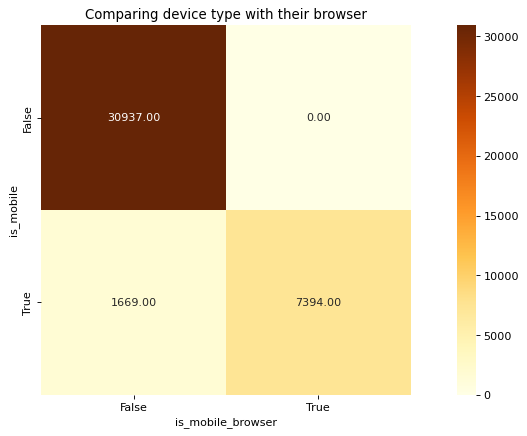

In [28]:
contingency_table = pd.crosstab(df['is_mobile'], df['is_mobile_browser'])
heatmap_from_contingency(contingency_table, "Comparing device type with their browser")

In [29]:
# this is done here because this change would affect the results of the cell checking for browsers linked to mobile
# the goal of the previous cell is to see if there are any non-mobile browsers
df['browser'] = df['browser'].apply(get_browser_family)
df.head(3)

,source_port,destination_port,protocol,packet_length,packet_type,traffic_type,payload_data,malware_indicators,anomaly_scores,alerts_and_warnings,attack_type,attack_signature,action_taken,severity_level,network_segment,geo-location_data,proxy_information,firewall_logs,ids_and_ips_alerts,log_source,hour,day_of_week,month,quarter,year,source_ip_address_is_private,destination_ip_address_is_private,source_country,destination_country,source_asn_id,destination_asn_id,browser,os,is_mobile,is_mobile_browser
0,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis ius...,IoC Detected,28.67,NaN,Malware,Known Pattern B,Logged,Low,Segment A,"Jamshedpur, Sikkim",150.9.97.135,Log Data,NaN,Server,6,1,5,2,2023,False,False,CN,GB,NaN,25310.0,IE,Windows,False,False
1,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omni...,IoC Detected,51.50,NaN,Malware,Known Pattern A,Blocked,Low,Segment B,"Bilaspur, Nagaland",NaN,Log Data,NaN,Firewall,7,2,8,3,2020,False,False,FR,US,12322.0,20115.0,IE,Windows,False,False
2,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectu...,IoC Detected,87.42,Alert Triggered,DDoS,Known Pattern B,Ignored,Low,Segment C,"Bokaro, Rajasthan",114.133.48.179,Log Data,Alert Data,Firewall,8,6,11,4,2022,False,False,US,US,701.0,NaN,IE,Windows,False,False


### Categorical Columns

In [30]:
get_categorical_vals(df, 15)

Skips booleans and numerics
Showing columns where the column unique value count is <= 15


,column,unique_values,count,notes
0,protocol,['ICMP' 'UDP' 'TCP'],3,
1,packet_type,['Data' 'Control'],2,
2,traffic_type,['HTTP' 'DNS' 'FTP'],3,
3,malware_indicators,['IoC Detected' nan],1,Possible boolean?
4,alerts_and_warnings,[nan 'Alert Triggered'],1,Possible boolean?
5,attack_type,['Malware' 'DDoS' 'Intrusion'],3,
6,attack_signature,['Known Pattern B' 'Known Pattern A'],2,
7,action_taken,['Logged' 'Blocked' 'Ignored'],3,
8,severity_level,['Low' 'Medium' 'High'],3,
9,network_segment,['Segment A' 'Segment B' 'Segment C'],3,


From the data generated above, we can see that some columns have few unique values. These values can indicate categories and therefore, they can be encoded making it easier for the algorithms to understand.
Both ordinal and nominal encoding should be considered.

Possible fields for ordinal encoding: severity_level

In addition that that, there are columns that contain only 1 unique value; usually the single value and others are populated by null values. Those columns can be possibly used as booleans. proxy_information is another good contender for a boolean since we won't need the exact values but rather if a proxy was detected.

In [31]:
df['has_proxy'] = np.where(df['proxy_information'].notnull(),True,False)
df['has_malware_indicator'] = np.where(df['malware_indicators'].notnull(),True,False)
df['has_alerts_and_warnings'] = np.where(df['alerts_and_warnings'].notnull(),True,False)
df['has_firewall_log'] = np.where(df['firewall_logs'].notnull(),True,False)
df['has_ids_ips_alert'] = np.where(df['ids_and_ips_alerts'].notnull(),True,False)

show_nulls(df)
df.head(3)

,source_port,destination_port,protocol,packet_length,packet_type,traffic_type,payload_data,malware_indicators,anomaly_scores,alerts_and_warnings,attack_type,attack_signature,action_taken,severity_level,network_segment,geo-location_data,proxy_information,firewall_logs,ids_and_ips_alerts,log_source,hour,day_of_week,month,quarter,year,source_ip_address_is_private,destination_ip_address_is_private,source_country,destination_country,source_asn_id,destination_asn_id,browser,os,is_mobile,is_mobile_browser,has_proxy,has_malware_indicator,has_alerts_and_warnings,has_firewall_log,has_ids_ips_alert
0,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis ius...,IoC Detected,28.67,NaN,Malware,Known Pattern B,Logged,Low,Segment A,"Jamshedpur, Sikkim",150.9.97.135,Log Data,NaN,Server,6,1,5,2,2023,False,False,CN,GB,NaN,25310.0,IE,Windows,False,False,True,True,False,True,False
1,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omni...,IoC Detected,51.50,NaN,Malware,Known Pattern A,Blocked,Low,Segment B,"Bilaspur, Nagaland",NaN,Log Data,NaN,Firewall,7,2,8,3,2020,False,False,FR,US,12322.0,20115.0,IE,Windows,False,False,False,True,False,True,False
2,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectu...,IoC Detected,87.42,Alert Triggered,DDoS,Known Pattern B,Ignored,Low,Segment C,"Bokaro, Rajasthan",114.133.48.179,Log Data,Alert Data,Firewall,8,6,11,4,2022,False,False,US,US,701.0,NaN,IE,Windows,False,False,True,True,True,True,True


We can see that 4 out of the 5 new bools are related to alerts so a new column can be created to concat them - if at least 1 is true, then the new column, has_system_alert, will be true.
Additionally, we can get an count of all alerts into a new column, alert_count.

In [32]:
def has_system_alert(row):
    return True if row['has_malware_indicator'] or row['has_alerts_and_warnings'] or row['has_firewall_log'] or row['has_ids_ips_alert'] else False

def count_alerts(row):
    count = 0

    if row['has_malware_indicator']:
        count+=1
    if row['has_alerts_and_warnings']:
        count+=1
    if row['has_firewall_log']:
        count+=1
    if row['has_ids_ips_alert']:
        count+=1
        
    return count
    
df['has_system_alert'] = df.apply(has_system_alert, axis=1)
df['alert_count'] = df.apply(count_alerts, axis=1)

print(df['has_system_alert'].value_counts())
df.head(3)

has_system_alert
True     37490
False     2510
Name: count, dtype: int64


,source_port,destination_port,protocol,packet_length,packet_type,traffic_type,payload_data,malware_indicators,anomaly_scores,alerts_and_warnings,attack_type,attack_signature,action_taken,severity_level,network_segment,geo-location_data,proxy_information,firewall_logs,ids_and_ips_alerts,log_source,hour,day_of_week,month,quarter,year,source_ip_address_is_private,destination_ip_address_is_private,source_country,destination_country,source_asn_id,destination_asn_id,browser,os,is_mobile,is_mobile_browser,has_proxy,has_malware_indicator,has_alerts_and_warnings,has_firewall_log,has_ids_ips_alert,has_system_alert,alert_count
0,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis ius...,IoC Detected,28.67,NaN,Malware,Known Pattern B,Logged,Low,Segment A,"Jamshedpur, Sikkim",150.9.97.135,Log Data,NaN,Server,6,1,5,2,2023,False,False,CN,GB,NaN,25310.0,IE,Windows,False,False,True,True,False,True,False,True,2
1,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omni...,IoC Detected,51.50,NaN,Malware,Known Pattern A,Blocked,Low,Segment B,"Bilaspur, Nagaland",NaN,Log Data,NaN,Firewall,7,2,8,3,2020,False,False,FR,US,12322.0,20115.0,IE,Windows,False,False,False,True,False,True,False,True,2
2,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectu...,IoC Detected,87.42,Alert Triggered,DDoS,Known Pattern B,Ignored,Low,Segment C,"Bokaro, Rajasthan",114.133.48.179,Log Data,Alert Data,Firewall,8,6,11,4,2022,False,False,US,US,701.0,NaN,IE,Windows,False,False,True,True,True,True,True,True,4


Well... based on the value_counts on has_system_alert, it looks useless, lol.

### Networking Stuff

The columns: protocol, packet_length, packet_type, traffic_type, payload_data can be combined somehow to create one or a few new columns.

In [33]:
for loc in ['source', 'destination']:
    df[f'{loc}_port_bin'] = df[f'{loc}_port'].apply(
        lambda value: "registered" if 1024 <= value <= 49151 else "dynamic"
    )

df['packet_length_bin'] = df['packet_length'].apply(
    lambda x: "Small" if x <= 256 else
    "Medium" if x <= 512 else
    "Large" if x <= 1024 else
    "Very Large"
)

df['packet_length_bin'].value_counts()

packet_length_bin
Large         14168
Very Large    13282
Medium         7143
Small          5407
Name: count, dtype: int64

In [34]:
def is_popular_port(port):
    return True if port in l_ports else False

df['is_popular_source_port'] = df['source_port'].apply(is_popular_port)
df['is_popular_destination_port'] = df['destination_port'].apply(is_popular_port)
df['protocol_uses_ports'] = df['protocol'].apply(lambda x : True if x == 'ICMP' else False)

print(df['is_popular_source_port'].value_counts())
print(df['is_popular_destination_port'].value_counts())
print(df['protocol_uses_ports'].value_counts())

is_popular_source_port
False    35419
True      4581
Name: count, dtype: int64
is_popular_destination_port
False    35485
True      4515
Name: count, dtype: int64
protocol_uses_ports
False    26571
True     13429
Name: count, dtype: int64


In [35]:
df['protocol_packet_type'] = df[['protocol', 'packet_type']].apply('_'.join, axis=1)
df['protocol_traffic_type'] = df[['protocol', 'packet_type']].apply('_'.join, axis=1)
df['source_port_bin__uses_port'] = df.apply(
    lambda x: '_'.join([x['source_port_bin'], str(x['protocol_uses_ports'])]), axis=1
)
df['destination_port_bin__uses_port'] = df.apply(
    lambda x: '_'.join([x['destination_port_bin'], str(x['protocol_uses_ports'])]), axis=1
)
df.head(3)

,source_port,destination_port,protocol,packet_length,packet_type,traffic_type,payload_data,malware_indicators,anomaly_scores,alerts_and_warnings,attack_type,attack_signature,action_taken,severity_level,network_segment,geo-location_data,proxy_information,firewall_logs,ids_and_ips_alerts,log_source,hour,day_of_week,month,quarter,year,source_ip_address_is_private,destination_ip_address_is_private,source_country,destination_country,source_asn_id,destination_asn_id,browser,os,is_mobile,is_mobile_browser,has_proxy,has_malware_indicator,has_alerts_and_warnings,has_firewall_log,has_ids_ips_alert,has_system_alert,alert_count,source_port_bin,destination_port_bin,packet_length_bin,is_popular_source_port,is_popular_destination_port,protocol_uses_ports,protocol_packet_type,protocol_traffic_type,source_port_bin__uses_port,destination_port_bin__uses_port
0,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis ius...,IoC Detected,28.67,NaN,Malware,Known Pattern B,Logged,Low,Segment A,"Jamshedpur, Sikkim",150.9.97.135,Log Data,NaN,Server,6,1,5,2,2023,False,False,CN,GB,NaN,25310.0,IE,Windows,False,False,True,True,False,True,False,True,2,registered,registered,Medium,False,False,True,ICMP_Data,ICMP_Data,registered_True,registered_True
1,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omni...,IoC Detected,51.50,NaN,Malware,Known Pattern A,Blocked,Low,Segment B,"Bilaspur, Nagaland",NaN,Log Data,NaN,Firewall,7,2,8,3,2020,False,False,FR,US,12322.0,20115.0,IE,Windows,False,False,False,True,False,True,False,True,2,registered,registered,Very Large,False,False,True,ICMP_Data,ICMP_Data,registered_True,registered_True
2,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectu...,IoC Detected,87.42,Alert Triggered,DDoS,Known Pattern B,Ignored,Low,Segment C,"Bokaro, Rajasthan",114.133.48.179,Log Data,Alert Data,Firewall,8,6,11,4,2022,False,False,US,US,701.0,NaN,IE,Windows,False,False,True,True,True,True,True,True,4,registered,dynamic,Medium,False,False,False,UDP_Control,UDP_Control,registered_False,dynamic_False


### Payload Data

The data could contain signs of an attack. Looks like auto-generated latin text.

In [36]:
df['payload_data'].tolist()[10000:10010]

['Eos eligendi occaecati impedit reprehenderit. Mollitia fugit ipsa a. Pariatur reprehenderit impedit quae cum. Amet nihil doloremque.',
 'Ipsa nam sequi ducimus nam fugit. Harum enim veniam.\nIste exercitationem natus temporibus inventore inventore ipsam. Nesciunt temporibus eaque ad odio nihil. Nihil aliquid et blanditiis.',
 'Deleniti quidem tenetur voluptates placeat corporis consectetur. Inventore illo sunt rem ipsam numquam.\nVoluptatibus ad facilis voluptas aperiam a quae. Laboriosam et beatae necessitatibus iste.',
 'Libero illo cupiditate sit. Ipsam recusandae dolores at deserunt.\nPraesentium sed sunt nihil. Veniam sint eum quisquam nesciunt deserunt officia.',
 'Nisi consectetur impedit accusamus aperiam. Quibusdam ea quas incidunt.\nDeleniti quidem suscipit cumque quae. Quidem eligendi natus est similique. Occaecati optio eum rem et deleniti.',
 'Asperiores dolorem nisi. Eligendi aperiam minus laboriosam.\nAliquam esse numquam architecto saepe in.\nProvident accusantium qua

### ASN & Countries

There is missing data in the countries and asn columns. Investigate.

In [37]:
show_nulls(df)

,0
malware_indicators,20000
alerts_and_warnings,20067
proxy_information,19851
firewall_logs,19961
ids_and_ips_alerts,20050
source_country,2
destination_country,7
source_asn_id,6604
destination_asn_id,6643


Since less than 10 countries are empty and about 15% ASN is empty, we can fill them with the modal value just to ensure the columns are filled for future tests.

In [38]:
df['source_country'].fillna(df['source_country'].mode()[0], inplace=True)
df['destination_country'].fillna(df['destination_country'].mode()[0], inplace=True)
df['source_asn_id'].fillna(df['source_asn_id'].mode()[0], inplace=True)
df['destination_asn_id'].fillna(df['destination_asn_id'].mode()[0], inplace=True)
show_nulls(df)

,0
malware_indicators,20000
alerts_and_warnings,20067
proxy_information,19851
firewall_logs,19961
ids_and_ips_alerts,20050


In [39]:
# the ASN IDs are supposed to be int rather than float
df['source_asn_id'] = df['source_asn_id'].astype(np.int64)
df['destination_asn_id'] = df['destination_asn_id'].astype(np.int64)
print(df.source_asn_id.dtype)
print(df.destination_asn_id.dtype)

int64
int64


'geo-location_data' has 8723 unique values - too many unique values. We already have location based on IP Address so we won't use that column.

In [40]:
#Ports with something else
# df['source_port_anomaly'] = df[['source_port_bin__uses_port', 'Anomaly Score']].apply('_'.join, axis=1)
# df['dest_port_anomaly'] = df[['destination_port_bin__uses_port', 'Anomaly Score']].apply('_'.join, axis=1)

df['source_port_action'] = df[['source_port_bin__uses_port', 'action_taken']].apply('_'.join, axis=1)
df['dest_port_action'] = df[['destination_port_bin__uses_port', 'action_taken']].apply('_'.join, axis=1)         

df['source_port_traf_type'] = df[['source_port_bin__uses_port', 'traffic_type']].apply('_'.join, axis=1)
df['dest_port_traf_type'] = df[['destination_port_bin__uses_port', 'traffic_type']].apply('_'.join, axis=1)

#Packet Lenght with something else
df['pckt_len_traf_tp'] = df[['packet_length_bin', 'traffic_type']].apply('_'.join, axis=1)
df['pckt_len_pckt_tp'] = df[['packet_length_bin', 'packet_type']].apply('_'.join, axis=1)
df['pckt_len_Protocol'] = df[['packet_length_bin', 'protocol']].apply('_'.join, axis=1)
df['pckt_len_Source'] = df[['packet_length_bin', 'log_source']].apply('_'.join, axis=1)

#Packet Type with something else
df['pckt_tp_Protocol'] = df[['packet_type', 'protocol']].apply('_'.join, axis=1)
df['pckt_tp_Source'] = df[['packet_type', 'log_source']].apply('_'.join, axis=1)
# df['pckt_tp_anomaly'] = df.apply(lambda x: '_'.join([str(x['packet_type']), str(x['anomaly_scores'])]), axis=1)

#Coutries
df['source_country_destination'] = df[['source_country', 'destination_country']].apply('_'.join, axis=1)

#Traffic Type with something else
# df['trf_tp_anomaly'] = df.apply(lambda x: '_'.join([str(x['anomaly_scores']), str(x['protocol'])]), axis=1)
df['trf_tp_protocol'] = df[['traffic_type', 'protocol']].apply('_'.join, axis=1)                           

#Crossing new columns with itselves
# df['trf_tp_protocol'] = df[['protocol_uses_ports', 'Protocol']].apply('_'.join, axis=1) 
# I guess you created this one but I'm not sure, I'll considere "protocol_uses_ports". If is wrong, I need to switch later

#protocol_uses_ports 
df['trf_tp_protocol_source_port_action'] = df[['trf_tp_protocol', 'source_port_action']].apply('_'.join, axis=1) 
df['trf_tp_protocol_dest_port_action'] = df[['trf_tp_protocol', 'dest_port_action']].apply('_'.join, axis=1) 

df['trf_tp_protocol_source_port_action_alert_warning'] = df.apply(
    lambda x: '_'.join([x['trf_tp_protocol_source_port_action'], str(x['has_alerts_and_warnings'])]), axis=1
)
df['trf_tp_protocol_dest_port_action_alert_warning'] = df.apply(
    lambda x: '_'.join([x['trf_tp_protocol_dest_port_action'], str(x['has_alerts_and_warnings'])]), axis=1
)

df['trf_tp_protocol_source_port_action_alert_warning_firewall'] = df.apply(
    lambda x: '_'.join([x['trf_tp_protocol_source_port_action_alert_warning'], str(x['has_firewall_log'])]), axis=1
)
df['trf_tp_protocol_dest_port_action_alert_warning_firewall'] = df.apply(
    lambda x: '_'.join([x['trf_tp_protocol_dest_port_action_alert_warning'], str(x['has_firewall_log'])]), axis=1
)

df['trf_tp_protocol_source_port_action_alert_warning_firewall_IOC'] = df.apply(
    lambda x: '_'.join([x['trf_tp_protocol_source_port_action_alert_warning_firewall'], str(x['has_malware_indicator'])]), axis=1
)
df['trf_tp_protocol_dest_port_action_alert_warning_firewall_IOC'] = df.apply(
    lambda x: '_'.join([x['trf_tp_protocol_dest_port_action_alert_warning_firewall'], str(x['has_malware_indicator'])]), axis=1
)

df['trf_tp_protocol_source_port_action_alert_warning_firewall_IOC'] = df[['trf_tp_protocol_source_port_action_alert_warning_firewall_IOC', 'action_taken']].apply('_'.join, axis=1) 
df['trf_tp_protocol_dest_port_action_alert_warning_firewall_IOC'] = df[['trf_tp_protocol_dest_port_action_alert_warning_firewall_IOC', 'action_taken']].apply('_'.join, axis=1) 

# df['pckt_tp_anomaly_pckt_tp'] = df[['pckt_tp_anomaly', 'packet_type']].apply('_'.join, axis=1) 

#trf_tp_protocol 
# df['trf_tp_protocol_anomaly'] = df.apply(lambda x: '_'.join([str(x['trf_tp_protocol']), str(x['anomaly_scores'])]), axis=1)
df['trf_tp_protocol_pckt_tp'] = df[['trf_tp_protocol', 'packet_type']].apply('_'.join, axis=1) 
df['trf_tp_protocol_traf_tp'] = df[['trf_tp_protocol', 'traffic_type']].apply('_'.join, axis=1) 
df['trf_tp_protocol_Sever_lv'] = df[['trf_tp_protocol', 'severity_level']].apply('_'.join, axis=1) 

#
df['trf_tp_protocol_source_port_action_ids'] = df.apply(
    lambda x: '_'.join([x['trf_tp_protocol_source_port_action'], str(x['has_ids_ips_alert'])]), axis=1
)
df['trf_tp_protocol_dest_port_action_ids'] = df.apply(
    lambda x: '_'.join([x['trf_tp_protocol_dest_port_action'], str(x['has_ids_ips_alert'])]), axis=1
)

df['trf_tp_protocol_source_port_action_ids_pckt_ln'] = df[['trf_tp_protocol_source_port_action_ids', 'packet_length_bin']].apply('_'.join, axis=1)
df['trf_tp_protocol_dest_port_action_ids_pckt-ln'] = df[['trf_tp_protocol_dest_port_action_ids', 'packet_length_bin']].apply('_'.join, axis=1)

df['source_country_destination_proxy'] = df.apply(
    lambda x: '_'.join([x['source_country_destination'], str(x['has_proxy'])]), axis=1
)

df['pckt_tp_Source_traf_tp'] = df[['traffic_type', 'pckt_tp_Source']].apply('_'.join, axis=1)

df.head(3)

,source_port,destination_port,protocol,packet_length,packet_type,traffic_type,payload_data,malware_indicators,anomaly_scores,alerts_and_warnings,attack_type,attack_signature,action_taken,severity_level,network_segment,geo-location_data,proxy_information,firewall_logs,ids_and_ips_alerts,log_source,hour,day_of_week,month,quarter,year,source_ip_address_is_private,destination_ip_address_is_private,source_country,destination_country,source_asn_id,destination_asn_id,browser,os,is_mobile,is_mobile_browser,has_proxy,has_malware_indicator,has_alerts_and_warnings,has_firewall_log,has_ids_ips_alert,has_system_alert,alert_count,source_port_bin,destination_port_bin,packet_length_bin,is_popular_source_port,is_popular_destination_port,protocol_uses_ports,protocol_packet_type,protocol_traffic_type,source_port_bin__uses_port,destination_port_bin__uses_port,source_port_action,dest_port_action,source_port_traf_type,dest_port_traf_type,pckt_len_traf_tp,pckt_len_pckt_tp,pckt_len_Protocol,pckt_len_Source,pckt_tp_Protocol,pckt_tp_Source,source_country_destination,trf_tp_protocol,trf_tp_protocol_source_port_action,trf_tp_protocol_dest_port_action,trf_tp_protocol_source_port_action_alert_warning,trf_tp_protocol_dest_port_action_alert_warning,trf_tp_protocol_source_port_action_alert_warning_firewall,trf_tp_protocol_dest_port_action_alert_warning_firewall,trf_tp_protocol_source_port_action_alert_warning_firewall_IOC,trf_tp_protocol_dest_port_action_alert_warning_firewall_IOC,trf_tp_protocol_pckt_tp,trf_tp_protocol_traf_tp,trf_tp_protocol_Sever_lv,trf_tp_protocol_source_port_action_ids,trf_tp_protocol_dest_port_action_ids,trf_tp_protocol_source_port_action_ids_pckt_ln,trf_tp_protocol_dest_port_action_ids_pckt-ln,source_country_destination_proxy,pckt_tp_Source_traf_tp
0,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis ius...,IoC Detected,28.67,NaN,Malware,Known Pattern B,Logged,Low,Segment A,"Jamshedpur, Sikkim",150.9.97.135,Log Data,NaN,Server,6,1,5,2,2023,False,False,CN,GB,749,25310,IE,Windows,False,False,True,True,False,True,False,True,2,registered,registered,Medium,False,False,True,ICMP_Data,ICMP_Data,registered_True,registered_True,registered_True_Logged,registered_True_Logged,registered_True_HTTP,registered_True_HTTP,Medium_HTTP,Medium_Data,Medium_ICMP,Medium_Server,Data_ICMP,Data_Server,CN_GB,HTTP_ICMP,HTTP_ICMP_registered_True_Logged,HTTP_ICMP_registered_True_Logged,HTTP_ICMP_registered_True_Logged_False,HTTP_ICMP_registered_True_Logged_False,HTTP_ICMP_registered_True_Logged_False_True,HTTP_ICMP_registered_True_Logged_False_True,HTTP_ICMP_registered_True_Logged_False_True_Tr...,HTTP_ICMP_registered_True_Logged_False_True_Tr...,HTTP_ICMP_Data,HTTP_ICMP_HTTP,HTTP_ICMP_Low,HTTP_ICMP_registered_True_Logged_False,HTTP_ICMP_registered_True_Logged_False,HTTP_ICMP_registered_True_Logged_False_Medium,HTTP_ICMP_registered_True_Logged_False_Medium,CN_GB_True,HTTP_Data_Server
1,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omni...,IoC Detected,51.50,NaN,Malware,Known Pattern A,Blocked,Low,Segment B,"Bilaspur, Nagaland",NaN,Log Data,NaN,Firewall,7,2,8,3,2020,False,False,FR,US,12322,20115,IE,Windows,False,False,False,True,False,True,False,True,2,registered,registered,Very Large,False,False,True,ICMP_Data,ICMP_Data,registered_True,registered_True,registered_True_Blocked,registered_True_Blocked,registered_True_HTTP,registered_True_HTTP,Very Large_HTTP,Very Large_Data,Very Large_ICMP,Very Large_Firewall,Data_ICMP,Data_Firewall,FR_US,HTTP_ICMP,HTTP_ICMP_registered_True_Blocked,HTTP_ICMP_registered_True_Blocked,HTTP_ICMP_registered_True_Blocked_False,HTTP_ICMP_registered_True_Blocked_False,HTTP_ICMP_registered_True_Blocked_False_True,HTTP_ICMP_registered_True_Blocked_False_True,HTTP_ICMP_registered_True_Blocked_False_True_T...,HTTP_ICMP_registered_True_Blocked_False_True_T...,HTTP_ICMP_Data,HTTP_ICMP_HTTP,HTTP_ICMP_Low,HTTP_ICMP_registered_True_Blocked_False,HTTP_ICMP_registered_True_Blocked_False,HTTP_ICMP_regist

### Drop Columns (Part 2)

The columns being dropped are based on the above sections of data transformation, like binning/bucketing, and finding useless columns.

In [41]:
columns_to_drop = [
    'malware_indicators', 'alerts_and_warnings', 'proxy_information', 'firewall_logs', 'ids_and_ips_alerts',
    'source_port', 'destination_port', 'packet_length', 'payload_data', 'geo-location_data'
]
df.drop(columns_to_drop, axis=1, inplace=True)

## More Analysis

In [42]:
show_nulls(df)

,0


In [43]:
show_dtypes(df)

,0
0,object
1,float64
2,int32
3,bool
4,int64


In [44]:
get_col_unique_vals(df, gte=15)

,0
anomaly_scores,9826
hour,24
source_country,188
destination_country,175
source_asn_id,4873
destination_asn_id,4803
source_country_destination,3288
trf_tp_protocol_source_port_action,54
trf_tp_protocol_dest_port_action,54
trf_tp_protocol_source_port_action_alert_warning,108


In [45]:
get_categorical_vals(df, 15)

Skips booleans and numerics
Showing columns where the column unique value count is <= 15


,column,unique_values,count,notes
0,protocol,['ICMP' 'UDP' 'TCP'],3,
1,packet_type,['Data' 'Control'],2,
2,traffic_type,['HTTP' 'DNS' 'FTP'],3,
3,attack_type,['Malware' 'DDoS' 'Intrusion'],3,
4,attack_signature,['Known Pattern B' 'Known Pattern A'],2,
5,action_taken,['Logged' 'Blocked' 'Ignored'],3,
6,severity_level,['Low' 'Medium' 'High'],3,
7,network_segment,['Segment A' 'Segment B' 'Segment C'],3,
8,log_source,['Server' 'Firewall'],2,
9,browser,['IE' 'Firefox' 'Opera' 'Chrome' 'Safari'],5,


#### Class Distribution (for target)

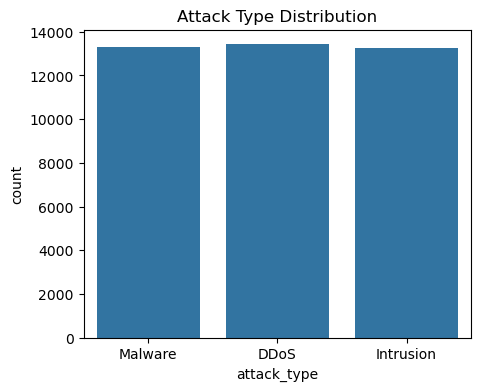

In [46]:
plt.figure(figsize=(5,4))
sns.countplot(x=df['attack_type'])
plt.title('Attack Type Distribution')
plt.show()

The graph above shows that the target variables are uniform.

### Some Preprocessing - Encoding - Feature Handling

Since there are different feature types, they have to be treated differently by the model and so they need to be encoded differently. We merge them using a ColumnTransformer. See documentation below:
- https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html
- https://inria.github.io/scikit-learn-mooc/python_scripts/03_categorical_pipeline_column_transformer.html

A class was developed to easily handle features during feature selection and model training.

In [190]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import TargetEncoder
from sklearn.preprocessing import StandardScaler
import re

class FeatureHandler():

    def __init__(self):
        self.X = df.drop(columns=['attack_type'])
        self.y = df['attack_type'].to_numpy()

        features_numeric = self.X.select_dtypes(include=['int32', 'int64', 'float64']).columns.values
        features_object = self.X.select_dtypes(include='object').columns.values
        features_specific = {
            'ordinal': ['severity_level', 'packet_length_bin'],
            'mean': [
                'source_country', 'destination_country', 'source_asn_id', 'destination_asn_id',
                'source_country_destination', 'trf_tp_protocol_source_port_action', 'trf_tp_protocol_dest_port_action',
                'trf_tp_protocol_source_port_action_alert_warning', 'trf_tp_protocol_dest_port_action_alert_warning',
                'trf_tp_protocol_source_port_action_alert_warning_firewall', 'trf_tp_protocol_dest_port_action_alert_warning_firewall',
                'trf_tp_protocol_source_port_action_alert_warning_firewall_IOC',
                'trf_tp_protocol_dest_port_action_alert_warning_firewall_IOC', 'trf_tp_protocol_pckt_tp',
                'trf_tp_protocol_Sever_lv', 'trf_tp_protocol_source_port_action_ids', 'trf_tp_protocol_dest_port_action_ids',
                'trf_tp_protocol_source_port_action_ids_pckt_ln', 'trf_tp_protocol_dest_port_action_ids_pckt-ln',
                'source_country_destination_proxy', 'pckt_tp_Source_traf_tp'
            ],
        }
        
        self.features = {
            'onehot': [x for x in features_object if x not in (features_specific['ordinal'] + features_specific['mean'])],
            'ordinal': features_specific['ordinal'],
            'mean': features_specific['mean'],
            'bool': list(self.X.select_dtypes(include='bool').columns.values),
            'numeric': [x for x in features_numeric if x not in (features_specific['ordinal'] + features_specific['mean'])]
        }

    def filter(self, selected_features):
        features = {}
        for f_type, values in self.features.items():
            features[f_type] = []
            for v in values:
                if v in selected_features:
                    features[f_type].append(v)

        self.features = features
        self.X = self.X[selected_features]

    @property
    def feature_count(self):
        count = 0
        for f_types in self.features:
            count += len(self.features[f_types])
        return count

    @property
    def preprocessor(self):

        ohe = OneHotEncoder(sparse_output=False, handle_unknown='error')
        oe_sl = OrdinalEncoder(categories=[['Low', 'Medium', 'High']])
        oe_pl = OrdinalEncoder(categories=[['Small', 'Medium', 'Large', 'Very Large']])
        te = TargetEncoder(target_type='multiclass', smooth='auto', cv=5)
        # sc = StandardScaler()

        transformers = []
        if self.features['onehot']:
            transformers.append(('onehot', ohe, self.features['onehot']))
        if 'severity_level' in self.features['ordinal']:
            transformers.append(('ordinal-sl', oe_sl, ['severity_level']))
        if 'packet_length_bin' in self.features['ordinal']:
            transformers.append(('ordinal-pl', oe_pl, ['packet_length_bin']))
        if self.features['mean']:
            transformers.append(('target', te, self.features['mean']))
        if self.features['bool']:
            transformers.append(('bool_passthrough', 'passthrough', self.features['bool']))
        if self.features['numeric']:
            transformers.append(('numeric_passthrough', 'passthrough', self.features['numeric']))
    
        return ColumnTransformer(transformers)

    def group_transformed_features(self, features_t):
        features = []
        for feature_t in features_t:
            split = feature_t.split('__', 1)
            preprocessor = split[0]
            feature_ = split[1]

            if preprocessor == 'target':
                feature_ = feature_[:-2]
            elif preprocessor == 'onehot':
                for f in self.features['onehot']:
                    pattern = r'(^|_)' + re.escape(f) + r'(_|$)'
                    if re.search(pattern, feature_):
                        feature_ = f
                        break

            if feature_ in features:
                continue
            features.append(feature_)
        return features

### Feature Selection

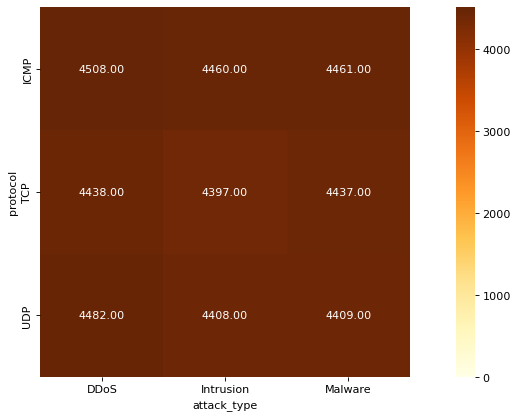

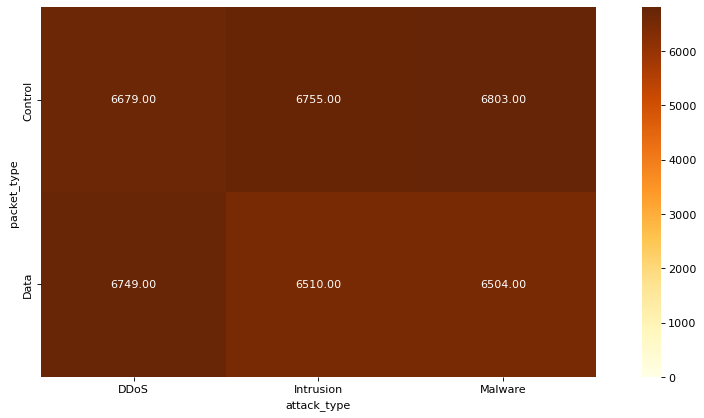

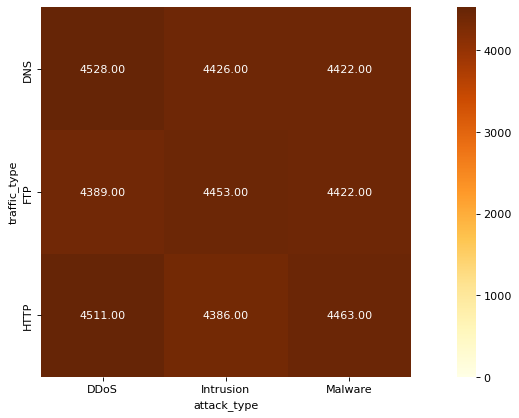

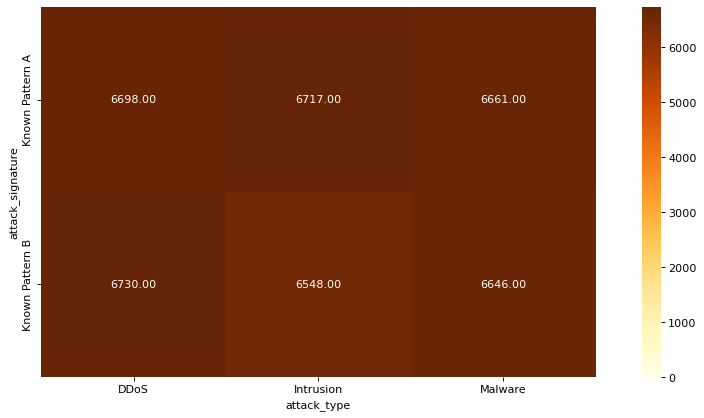

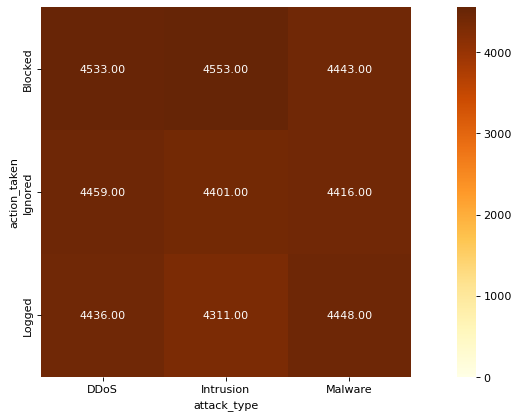

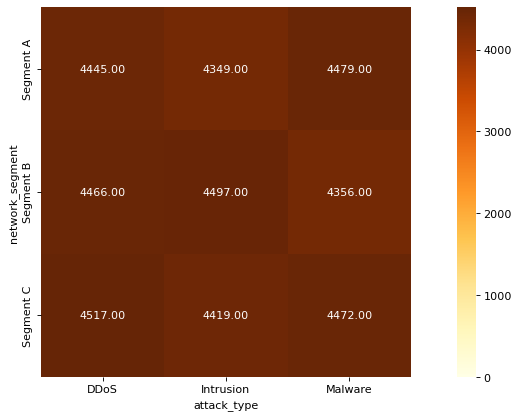

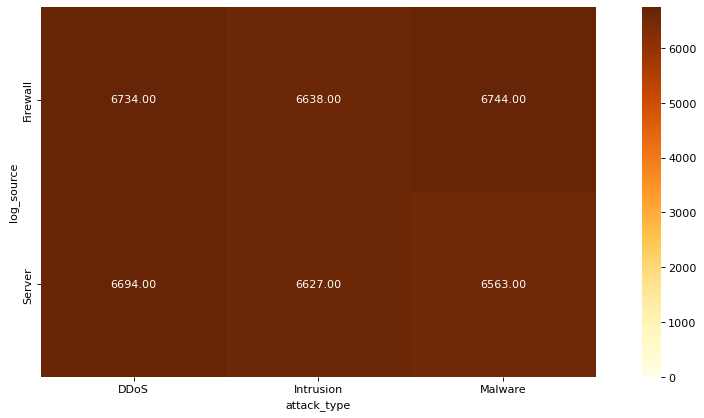

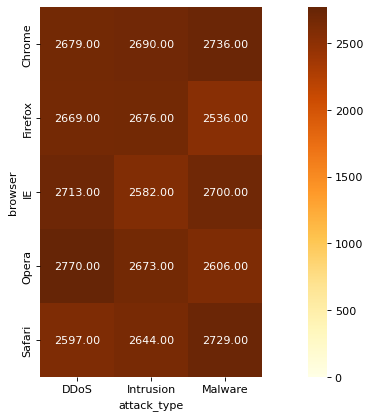

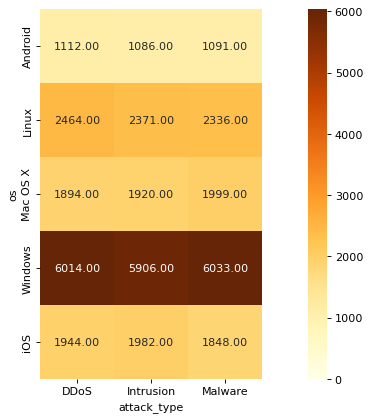

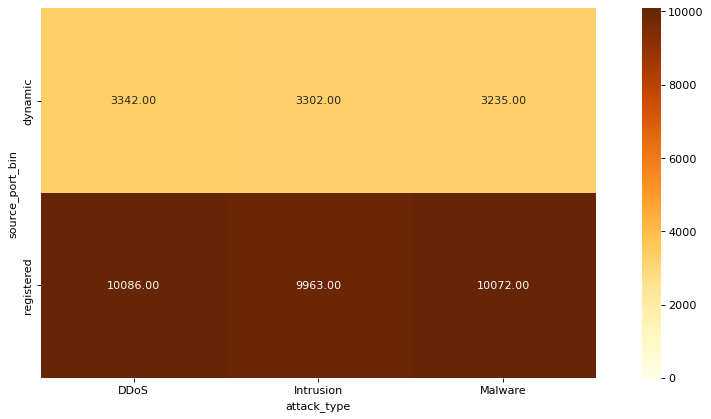

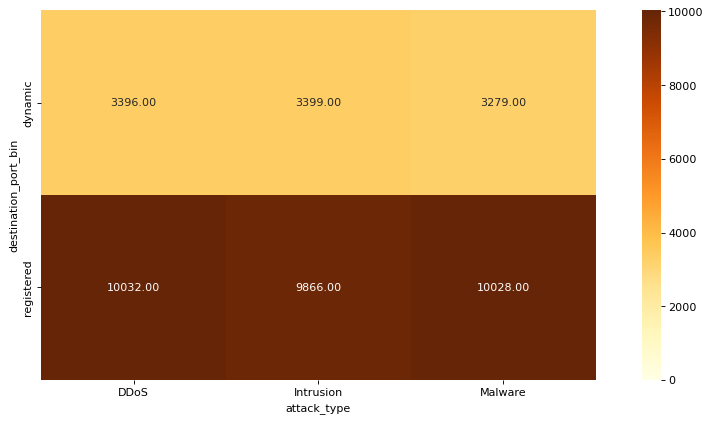

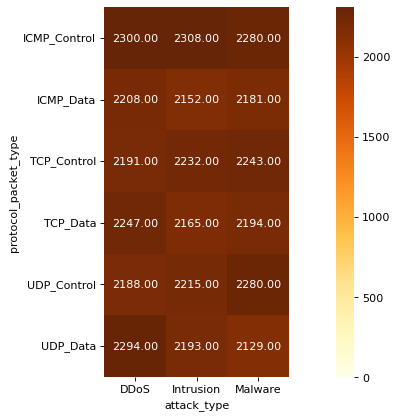

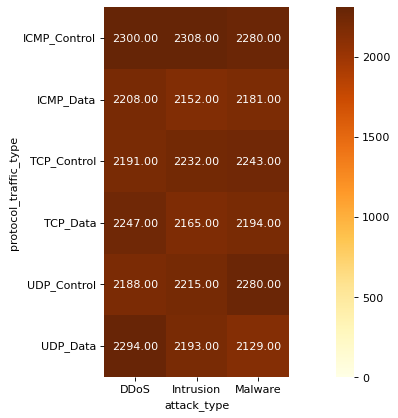

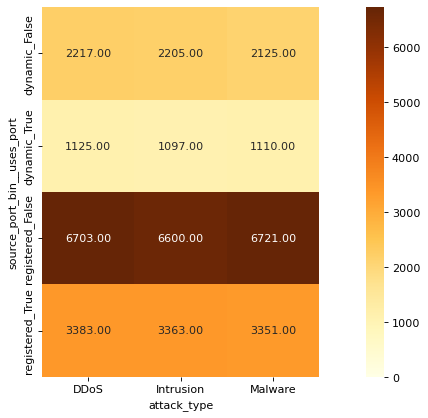

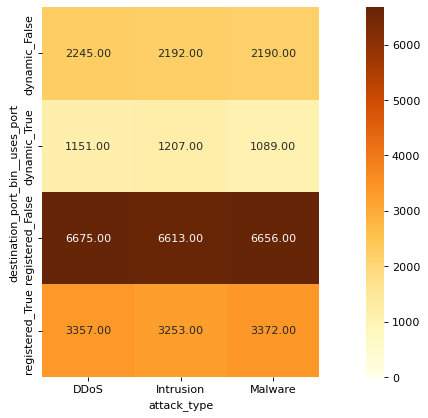

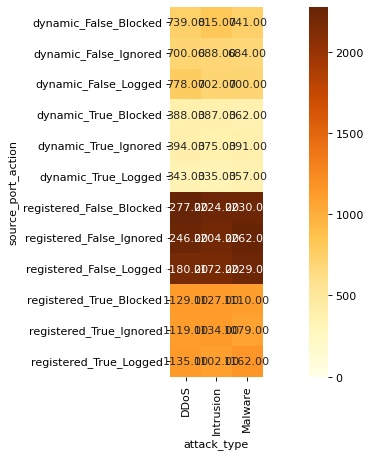

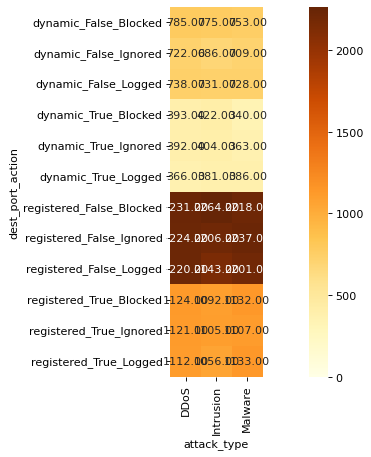

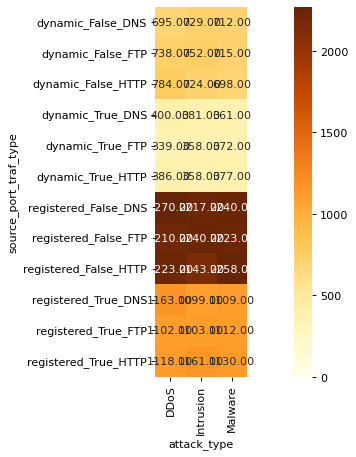

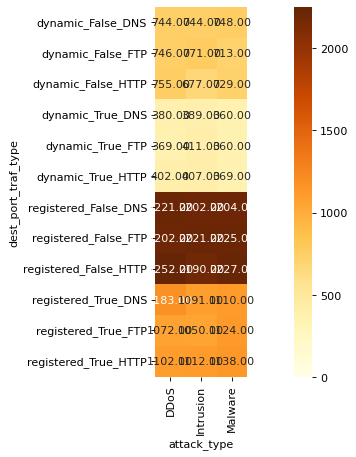

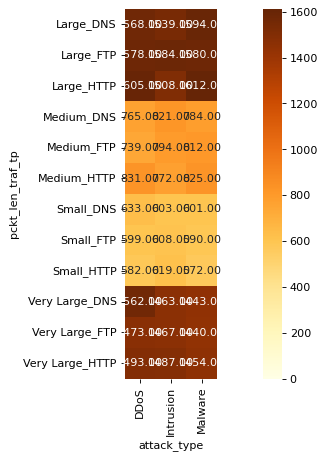

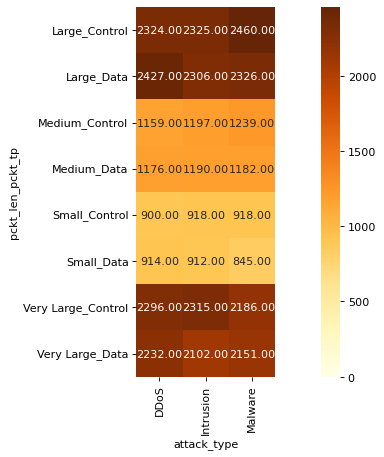

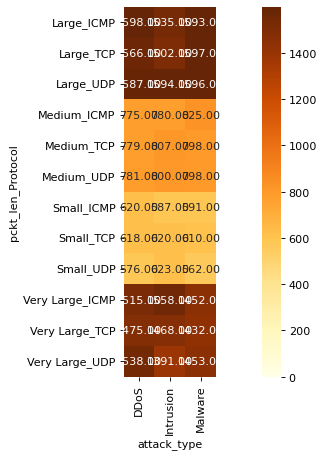

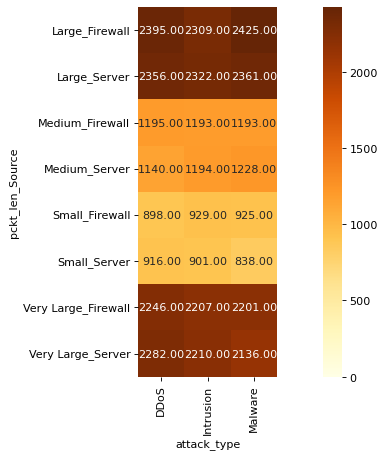

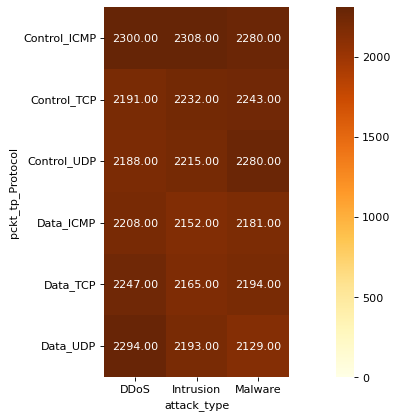

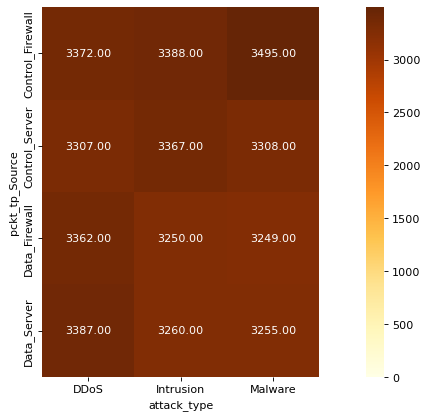

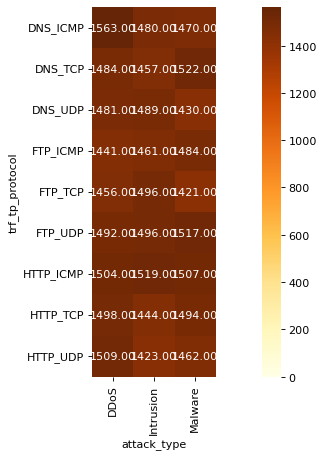

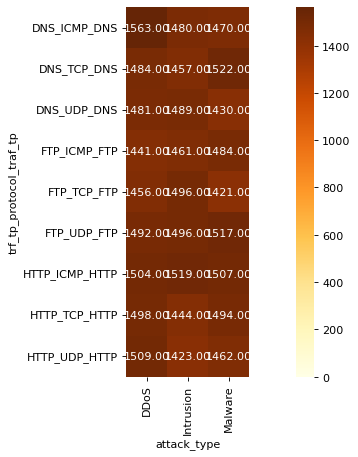

In [163]:
fh_fc = FeatureHandler()
for feature in fh_fc.features['onehot']:
    contingency_table = pd.crosstab(df[feature], df['attack_type'])
    heatmap_from_contingency(contingency_table)

#### Chi^2

We can check categorical using chi squared, then numerical using...

"The Chi-square test is a statistical test that is used to determine whether there is a significant difference between the observed frequency of a categorical variable and the expected frequency based on the assumption of independence. It can be used to select the best categorical features for a classification model."
From: https://datascience.stackexchange.com/questions/117287/are-chi-square-and-anova-f-classif-to-select-best-features

"The Chi-Square test determines whether there is a significant association between two categorical variables. It helps in hypothesis testing to check whether observed frequencies differ from expected ones."
"If the p-value is less than the significance level (typically 0.05), reject the null hypothesis, indicating a significant relationship between the variables.
If the p-value is greater than 0.05, fail to reject the null hypothesis, meaning no significant relationship was found."
From: https://www.simplilearn.com/tutorials/statistics-tutorial/chi-square-test

In [49]:
from scipy.stats import chi2_contingency

def chi_square_test(feature):
    contingency_table = pd.crosstab(df[feature], df['attack_type'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return feature, chi2, p

def plot_chi_square(chi_square_df):
    fig, axs = plt.subplots(1,2)
    chi2_df = chi_square_df.sort_values(by='chi2', ascending=False)
    pv_df = chi_square_df.sort_values(by='p', ascending=True) 
    chi2_df.plot.bar(x='feature', y='chi2', figsize=(13,4), ax=axs[0])
    pv_df.plot.bar(x='feature', y='p', ax=axs[1])

,feature,chi2,p
1,packet_type,5.992260,0.049980
7,browser,16.683922,0.033574
3,is_mobile_browser,7.725519,0.021010


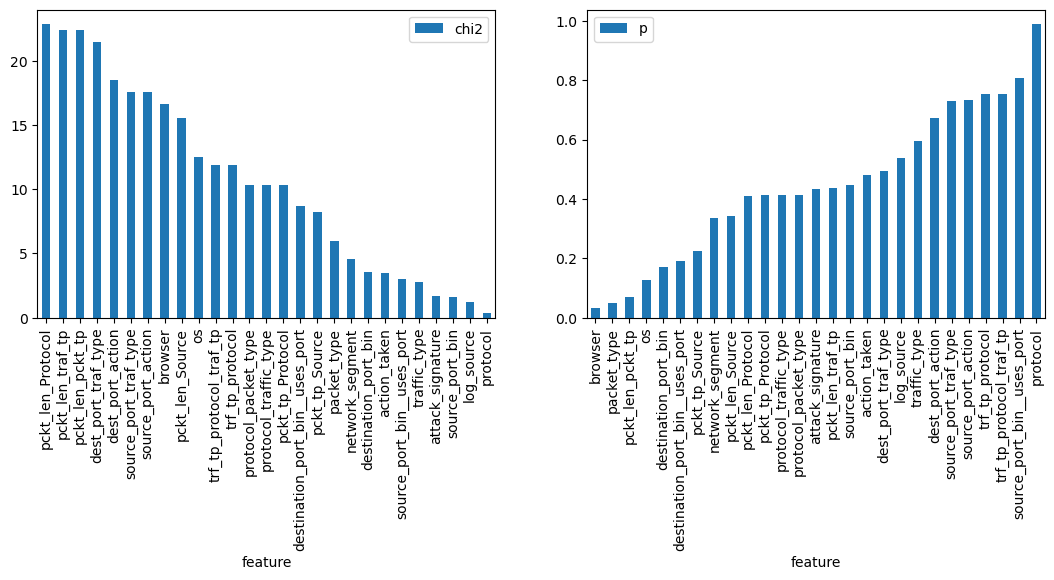

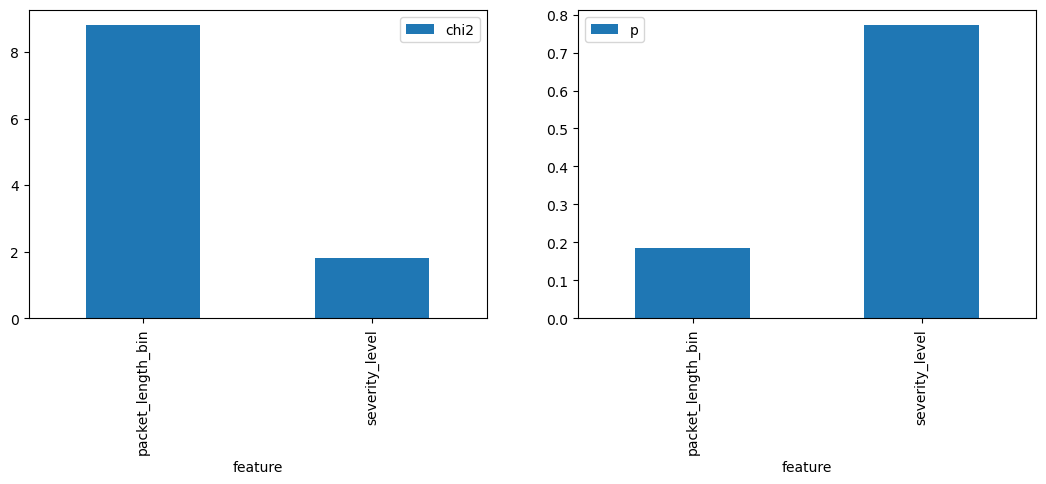

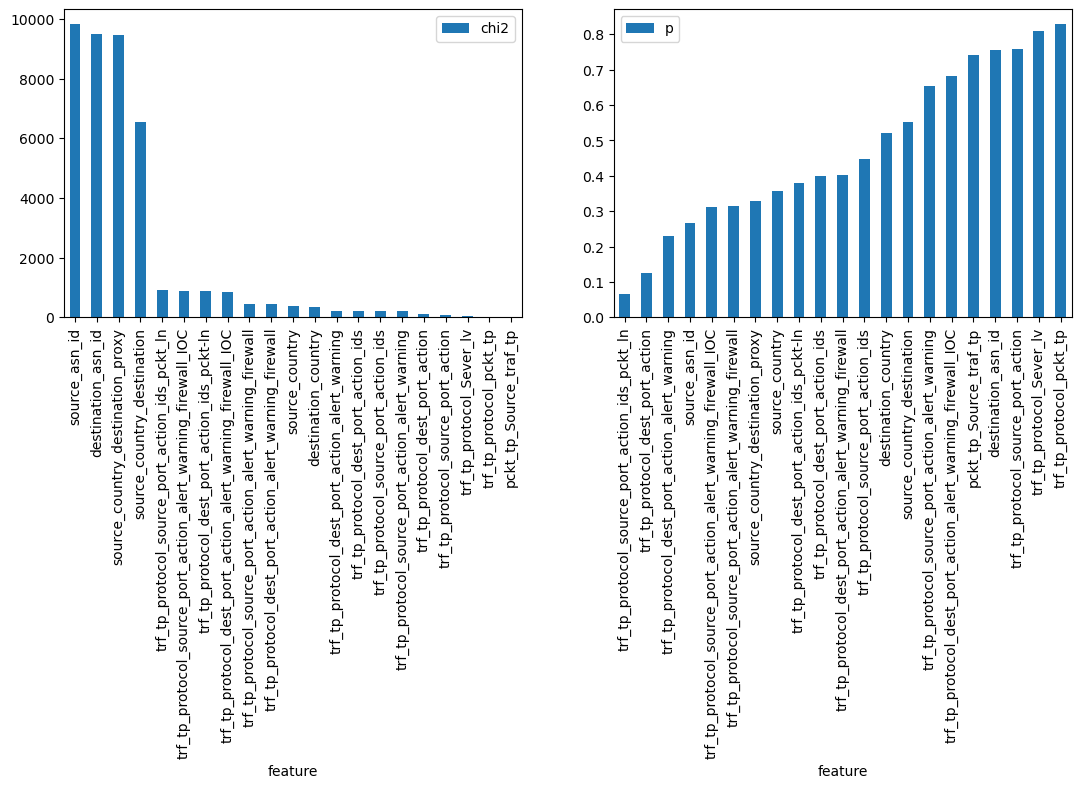

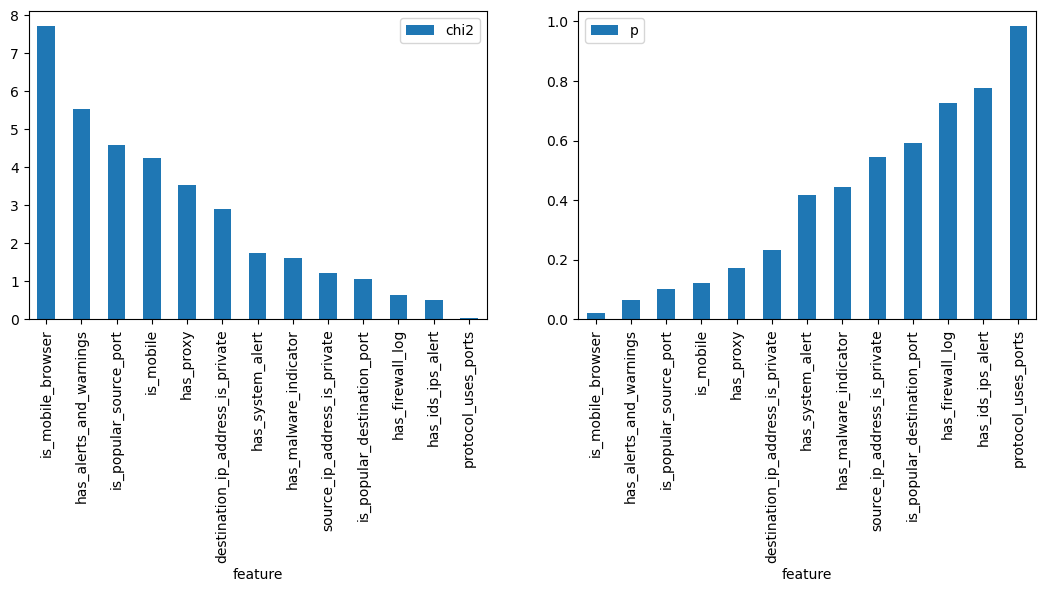

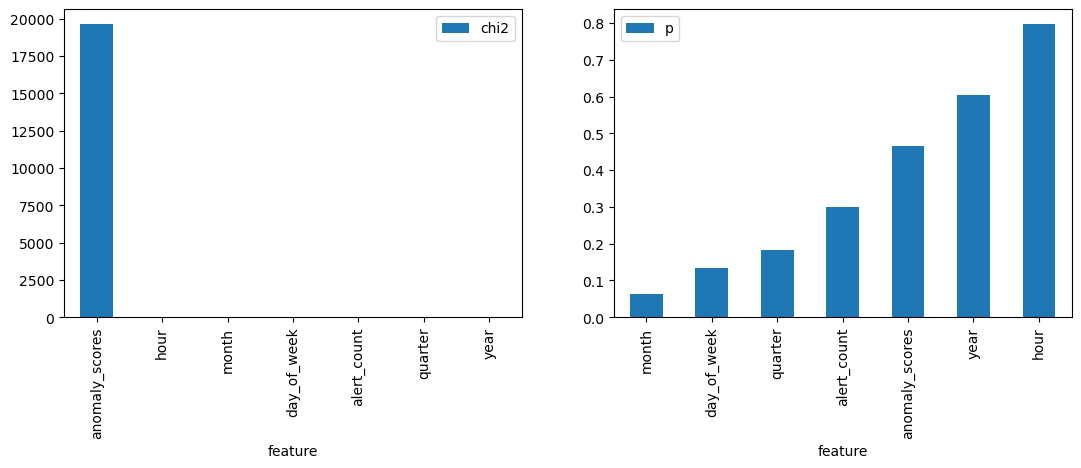

In [50]:
appended = []
fh = FeatureHandler()

for features in fh.features.values():
    chi_square_results = [chi_square_test(feature) for feature in features]
    chi_square_df = pd.DataFrame(chi_square_results, columns=['feature', 'chi2', 'p'])
    appended.append(chi_square_df)
    plot_chi_square(chi_square_df)

chi_square_df_full = pd.concat(appended)
# features with p-values < 0.05 are statistically significant
chi_square_df_full[chi_square_df_full['p'] < 0.05]

### Feature Selection Model Setup

This section includes initializations and definitions for wrapper functions and models. Parameter settings here too.

In [191]:
from sklearn.base import BaseEstimator, ClassifierMixin

class PipelineTargetTransformerWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, pipeline):
        self.pipeline = pipeline
        self.target_transformer = LabelEncoder()
    
    def fit(self, X, y):
        y_transformed = self.target_transformer.fit_transform(y)
        self.pipeline.fit(X, y_transformed)
        return self
    
    def predict(self, X):
        y_pred_transformed = self.pipeline.predict(X)
        return self.target_transformer.inverse_transform(y_pred_transformed)

    def score(self, X_test, y_test):
        return self.pipeline.score(X_test, y_test)

In [195]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

fh = FeatureHandler()
fh.filter([
    'packet_type', 'browser', 'is_mobile_browser', 'packet_length_bin', 'has_alerts_and_warnings'
])
X_train, X_test, y_train, y_test = train_test_split(fh.X, fh.y, test_size=0.2, shuffle=True, stratify=fh.y, random_state=42)

rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
gbc = GradientBoostingClassifier(max_depth=5, random_state=42)
lr = LinearRegression()
logr = LogisticRegression()

fh.preprocessor

ColumnTransformer(transformers=[('onehot', OneHotEncoder(sparse_output=False),
                                 ['packet_type', 'browser']),
                                ('ordinal-pl',
                                 OrdinalEncoder(categories=[['Small', 'Medium',
                                                             'Large',
                                                             'Very Large']]),
                                 ['packet_length_bin']),
                                ('bool_passthrough', 'passthrough',
                                 ['is_mobile_browser',
                                  'has_alerts_and_warnings'])])

#### Baselines

In [198]:
# Linear Regression

# pl_base_lr = PipelineTargetTransformerWrapper(make_pipeline(fh.preprocessor, lr))
pl_base_lr = PipelineTargetTransformerWrapper(
    make_pipeline(fh.preprocessor, lr)
)
pl_base_lr.fit(X_train, y_train)
# pl_base_lr_pred = pl_base_lr.predict(X_test)
pl_base_lr.score(X_test, y_test)
# print(classification_report(y_test, pl_base_lr_pred))

ValueError: could not convert string to float: 'Malware'

In [199]:
# Logistic Regression

pl_base_logr = PipelineTargetTransformerWrapper(
    make_pipeline(fh.preprocessor, logr)
)
pl_base_logr.fit(X_train, y_train)
pl_base_logr_pred = pl_base_logr.predict(X_test)
# pl_base_logr.score(X_test, y_test)
print(classification_report(y_test, pl_base_logr_pred))

              precision    recall  f1-score   support

        DDoS       0.34      0.38      0.36      2686
   Intrusion       0.34      0.21      0.26      2653
     Malware       0.34      0.42      0.37      2661

    accuracy                           0.34      8000
   macro avg       0.34      0.34      0.33      8000
weighted avg       0.34      0.34      0.33      8000



In [200]:
# Random Forest Classifier

pl_base_rfc = PipelineTargetTransformerWrapper(
    make_pipeline(fh.preprocessor, rfc)
)
pl_base_rfc.fit(X_train, y_train)
pl_base_rfc_pred = pl_base_rfc.predict(X_test)
# pl_base_rfc.score(X_test, y_test)
print(classification_report(y_test, pl_base_rfc_pred))

              precision    recall  f1-score   support

        DDoS       0.33      0.33      0.33      2686
   Intrusion       0.33      0.27      0.30      2653
     Malware       0.33      0.38      0.35      2661

    accuracy                           0.33      8000
   macro avg       0.33      0.33      0.33      8000
weighted avg       0.33      0.33      0.33      8000



In [201]:
# Gradient Boosting Classifier

pl_base_gbc = PipelineTargetTransformerWrapper(
    make_pipeline(fh.preprocessor, gbc)
)
pl_base_gbc.fit(X_train, y_train)
pl_base_gbc_pred = pl_base_gbc.predict(X_test)
# pl_base_gbc.score(X_test, y_test)
print(classification_report(y_test, pl_base_gbc_pred))

              precision    recall  f1-score   support

        DDoS       0.33      0.35      0.34      2686
   Intrusion       0.33      0.28      0.30      2653
     Malware       0.34      0.36      0.35      2661

    accuracy                           0.33      8000
   macro avg       0.33      0.33      0.33      8000
weighted avg       0.33      0.33      0.33      8000



#### Cross Val

In [202]:
from sklearn.model_selection import cross_val_score

pl_wo_fs = PipelineTargetTransformerWrapper(
    make_pipeline(fh.preprocessor, logr)
)
# splits data on its own using K-fold by default; 5-fold
cross_val_score(pl_wo_fs.pipeline, fh.X, fh.y, scoring='accuracy')

array([0.336375, 0.340625, 0.335625, 0.339875, 0.344375])

In [203]:
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import mutual_info_classif

selector_percent = SelectPercentile(mutual_info_classif, percentile=20)
pl_w_fs = PipelineTargetTransformerWrapper(
    make_pipeline(fh.preprocessor, selector_percent, logr)
)
cross_val_score(pl_w_fs.pipeline, fh.X, fh.y, scoring='accuracy')

array([0.342125, 0.3365  , 0.334875, 0.337875, 0.33775 ])

#### Model Inspection

##### Permutation Importance

Needs one of the classifiers: Random Forest, Gradient Boosting, etc.

In [204]:
from sklearn.inspection import permutation_importance

# https://stackoverflow.com/questions/62106204/permutation-importance-using-a-pipeline-in-scikit-learn
# https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html
# https://scikit-learn.org/stable/modules/permutation_importance.html
perm_importances = permutation_importance(pl_base_gbc, X_test, y_test, n_repeats=30, random_state=0)

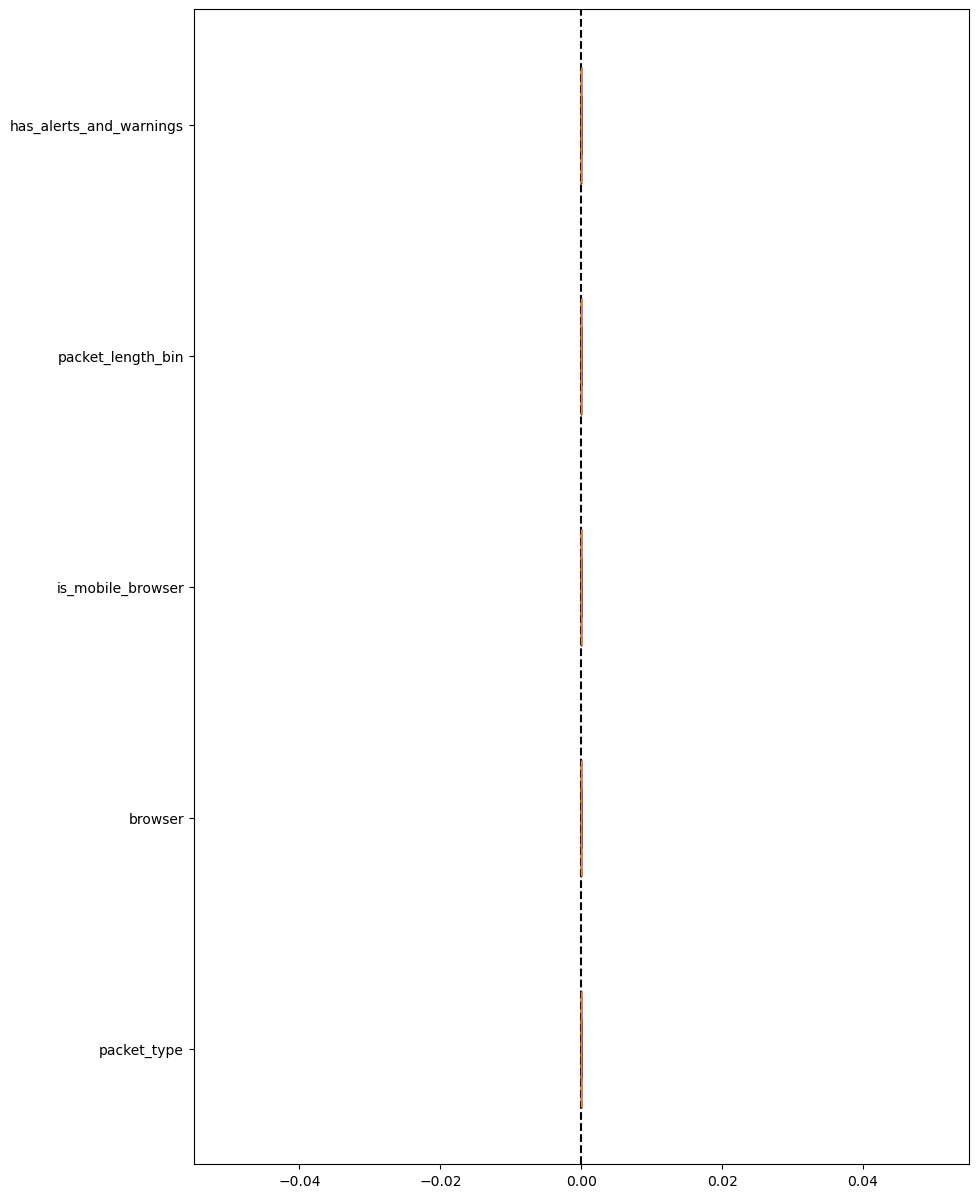

In [205]:
fig, ax = plt.subplots(figsize=(10, 15))
perm_sorted_idx = perm_importances.importances_mean.argsort()
tick_labels_dict = {'tick_labels': fh.X.columns[perm_sorted_idx]}
ax.boxplot(perm_importances.importances[perm_sorted_idx].T, vert=False, **tick_labels_dict)
ax.axvline(x=0, color='k', linestyle="--")

##### Feature Importance (from Random Forest Classifier)

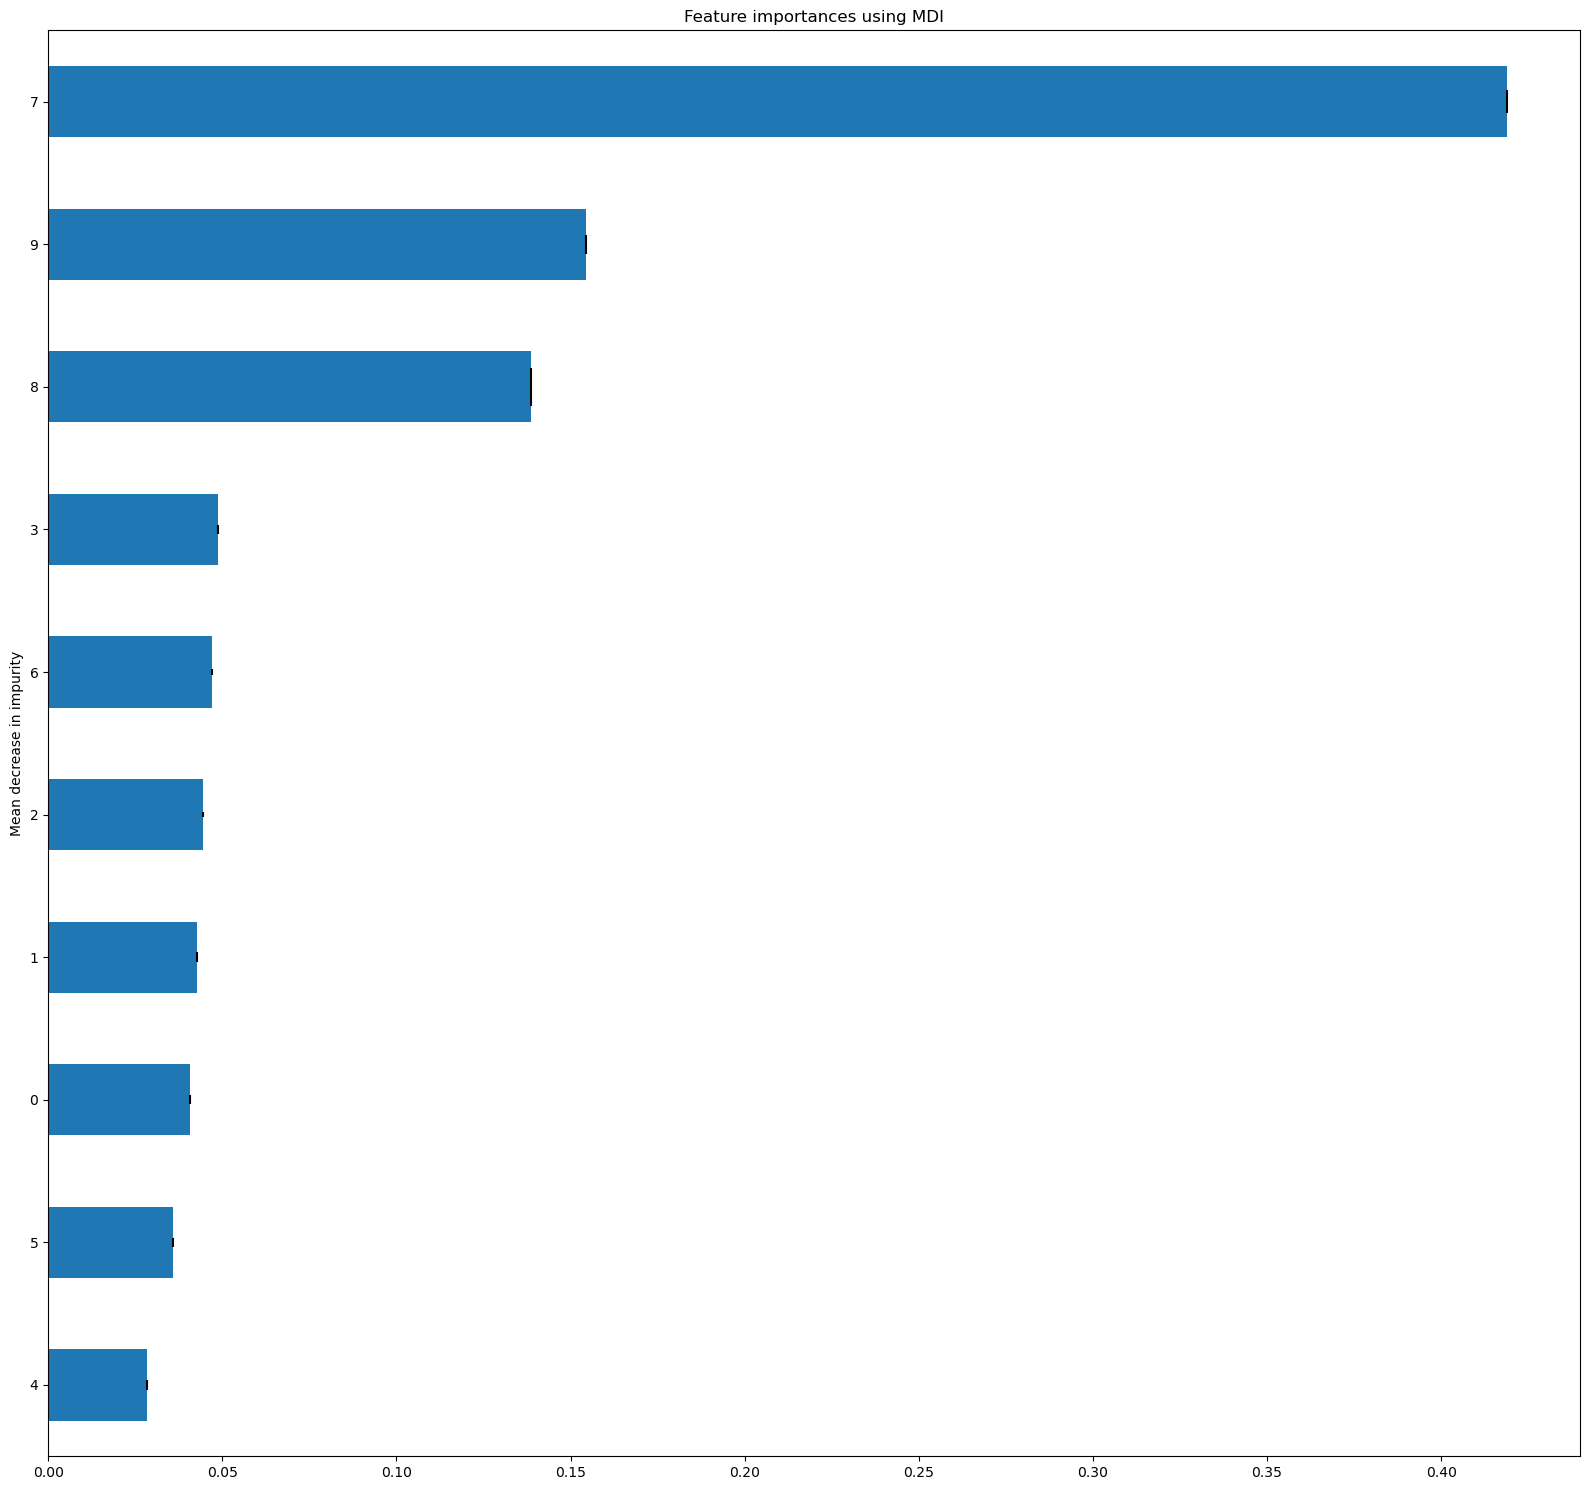

In [206]:
# Accessing the properties from classifier is different when using a pipeline because
# the classifier is an object within the pipeline
# https://stackoverflow.com/questions/38787612/how-to-extract-feature-importances-from-an-sklearn-pipeline

# importances = pd.Series(pl_base_rfc.pipeline.steps[1][1].feature_importances_, index=pl_base_rfc.pipeline[:-1].get_feature_names_out())
feat_importances = pd.Series(pl_base_rfc.pipeline.steps[1][1].feature_importances_)
std = np.std([tree.feature_importances_ for tree in pl_base_rfc.pipeline.steps[1][1].estimators_], axis=0)

fig, ax = plt.subplots()
feat_importances.sort_values().plot.barh(yerr=std, ax=ax, figsize=(16,15))
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#### Feature Selection for Supervised Models

Classifier models are best used here.

In [208]:
def graph_feature_selection_supervised(f1_score_list, feature_count):
    fig, ax = plt.subplots(figsize=(12,4))

    x = np.arange(1, feature_count+1)
    y = f1_score_list
    
    ax.bar(x, y)
    ax.set_xlabel('Num features')
    ax.set_ylabel('F1 Score (weighted)')
    ax.set_ylim(0, 1.0)
    # ax.set_xticks(np.arange(1, fh.feature_count+1))
    # ax.set_xticklabels(np.arange(1, fh.feature_count+1))
    
    for i,v in enumerate(y):
        plt.text(x=i+1, y=v+0.05, s=str(v), ha='center', rotation='vertical')
    
    plt.tight_layout()

##### SelectKBest with (chi2, mutual_info_classif, f_classif)

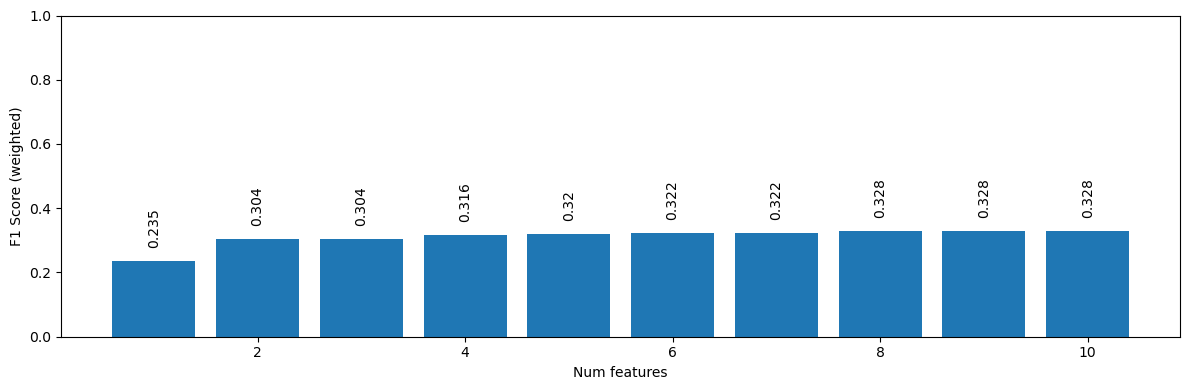

In [209]:
from sklearn.feature_selection import SelectKBest, chi2

f1_score_list_kbest = []
X_train_1, X_test_1, y_train_1, y_test_1 = X_train, X_test, y_train, y_test

# options for this dataset: chi2, mutual_info_classif, f_classif
score_func = chi2
feature_count = 1 # only to get it started
k = 1
while(k <= feature_count):
    pl_kbest = PipelineTargetTransformerWrapper(
        make_pipeline(fh.preprocessor, SelectKBest(score_func, k=k), rfc)
    )
    pl_kbest.fit(X_train_1, y_train_1)
    pl_kbest_pred = pl_kbest.predict(X_test_1)
    pl_kbest_f1_score = round(f1_score(y_test_1, pl_kbest_pred, average='weighted'), 3)
    f1_score_list_kbest.append(pl_kbest_f1_score)

    feature_count = len(pl_kbest.pipeline[0].get_feature_names_out())
    k += 1

graph_feature_selection_supervised(f1_score_list_kbest, feature_count)

In [210]:
pl_kbest = make_pipeline(fh.preprocessor, SelectKBest(score_func, k=8))
pl_kbest.fit(X_train_1, y_train_1)

selected_feature_mask = pl_kbest[1].get_support()
selected_features = pl_kbest[0].get_feature_names_out()[selected_feature_mask]
print(selected_features)
fh.group_transformed_features(selected_features)

['onehot__packet_type_Control' 'onehot__packet_type_Data'
 'onehot__browser_Firefox' 'onehot__browser_IE' 'onehot__browser_Opera'
 'onehot__browser_Safari' 'bool_passthrough__is_mobile_browser'
 'bool_passthrough__has_alerts_and_warnings']


['packet_type', 'browser', 'is_mobile_browser', 'has_alerts_and_warnings']

##### Recursive Feature Elimination

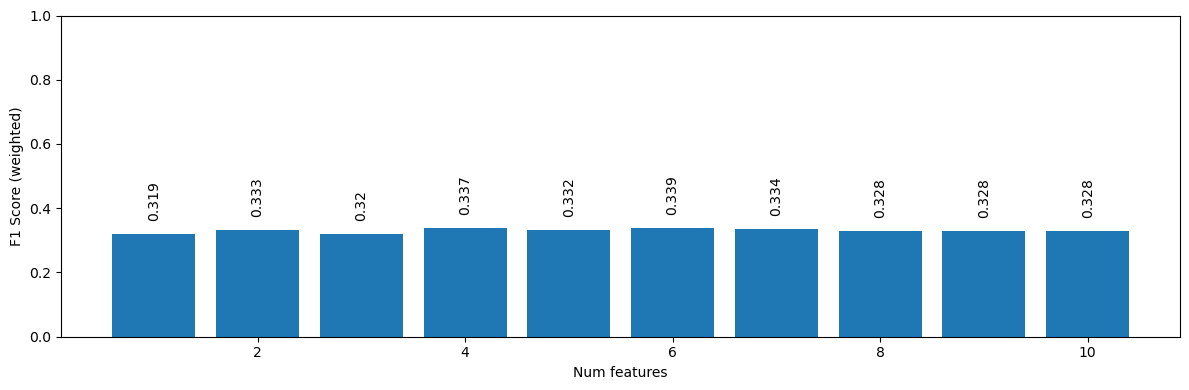

In [211]:
from sklearn.feature_selection import RFE

f1_score_list_rfe = []
X_train_2, X_test_2, y_train_2, y_test_2 = X_train, X_test, y_train, y_test

feature_count = 1 # only to get it started
k = 1
while(k <= feature_count):
    pl_rfe = PipelineTargetTransformerWrapper(
        make_pipeline(fh.preprocessor, RFE(estimator=rfc, n_features_to_select=k, step=1))
    )
    pl_rfe.fit(X_train_2, y_train_2)
    pl_rfe_pred = pl_rfe.predict(X_test_2)
    pl_rfe_f1_score = round(f1_score(y_test_2, pl_rfe_pred, average='weighted'), 3)
    f1_score_list_rfe.append(pl_rfe_f1_score)

    feature_count = len(pl_rfe.pipeline[0].get_feature_names_out())
    k += 1

graph_feature_selection_supervised(f1_score_list_rfe, feature_count)

In [212]:
pl_rfe = make_pipeline(fh.preprocessor, RFE(estimator=rfc, n_features_to_select=6, step=10))
pl_rfe.fit(X_train_1, y_train_1)

selected_feature_mask = pl_rfe[1].get_support()
selected_features = pl_rfe[0].get_feature_names_out()[selected_feature_mask]
print(selected_features)
fh.group_transformed_features(selected_features)

['onehot__browser_Chrome' 'onehot__browser_Firefox'
 'onehot__browser_Safari' 'ordinal-pl__packet_length_bin'
 'bool_passthrough__is_mobile_browser'
 'bool_passthrough__has_alerts_and_warnings']


['browser',
 'packet_length_bin',
 'is_mobile_browser',
 'has_alerts_and_warnings']

## Final Model

### Training

In [213]:
fh_model = FeatureHandler()
fh_model.filter([
    'browser', 'is_mobile_browser', 'packet_length_bin', 'has_alerts_and_warnings'
])
X_train_model, X_test_model, y_train_model, y_test_model = train_test_split(
    fh_model.X, fh_model.y, test_size=0.2, shuffle=True, stratify=fh_model.y, random_state=42
)

pl_model = PipelineTargetTransformerWrapper(
    make_pipeline(fh_model.preprocessor, logr)
)
pl_model.fit(X_train, y_train)
pred = pl_model.predict(X_test)
print(pl_model.score(X_test, y_test))

f1_score_gbc = round(f1_score(y_test, pred, average='weighted'), 3)
f1_score_gbc

0.0


0.334

### Persistence

In [214]:
import dill

with open("../model/model_pl_wrapper.pckl","wb") as f:
    dill.dump(pl_model, f)